# Demonstrating Ensemble Pruning

Just a simple and potentially (likely?) stupid approch to the value of ensemble pruning the BOP-DMD.

Uses the exponentially growing simple example toy data.

# Setup

## Imports

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import pydmd
from pydmd.bopdmd import BOPDMD
import colorednoise as cn

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter

## Quick word on warnings:

The optDMD raises several warnings. They are disabled by the below lines to make the output of the examples cleaner, but there are several points that need to be cleaned up.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# A REALLY STUPID workaround until I make this a package.
# get_directories = True
# if get_directories:
#     notebook_dir = os.getcwd()
#     package_dir = os.path.join(notebook_dir, '../..')
#     sys.path.append(package_dir)
#     from py_optDMD.src import *
#     get_directories = False

from pyoptdmd import optimalDMD
from pyoptdmd import bop_dmd as kl_bopdmd

## Format plots

In [4]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
sns.set_context('paper')

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    '#4477AA',
    '#CCBB44',
    '#EE6677',
    '#228833',
    '#66CCEE',
    '#AA3377',
    '#BBBBBB'
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

# BOP-DMD


## Helper functions

### xarray containers for ensemble results

This is not strictly necessary, but xarray is a nice data container that enables easier exploration of ensemble results.

In [5]:
def build_ensemble_xarray(data, ds_previous=None, num_eigenvalues=3,
                          column_name='ensemble member',
                          concat_dim='cycle', variable_name='eigenvalue'):
    """Convert the results to an xarray Dataset.
    
    Dataset has coordinates of index (a melt of eigenvalue and ensemble member) 
    and cycle (number of ensembles created). The cycle dimension is the dimension
    along which ensembles are stacked in the concatenation.
    """
    
    # Build the eigenvalues dimension
    eigenvalues_coord = [str(k) for k in np.arange(1, num_eigenvalues + 1)]
    
    # Convert to a Pandas dataframe to use the melt function.
    # Build the real component
    df_real = pd.DataFrame(
        data=data.real,
    )

    df_real[variable_name] = eigenvalues_coord
    df_real.columns.names = [column_name]

    df_real = pd.melt(df_real, id_vars=variable_name, value_name='real')

    mi = pd.MultiIndex.from_frame(df_real[[column_name, variable_name]])
    df_real.index = mi
    df_real = df_real.drop([column_name, variable_name], axis=1)

    # Build the imaginary component.
    df_imag = pd.DataFrame(
        data=data.imag,
    )

    df_imag[variable_name] = eigenvalues_coord
    df_imag.columns.names = [column_name]

    df_imag = pd.melt(df_imag, id_vars=variable_name, value_name='imag')

    mi = pd.MultiIndex.from_frame(df_imag[[column_name, variable_name]])
    df_imag.index = mi
    df_imag = df_imag.drop([column_name, variable_name], axis=1)

    # Concatenate the real and imaginary components into a single Dataframe.
    df = pd.concat(
        [df_real, df_imag], axis=1
    )

    # Convert to xarray since this better handles the multidimensional data.
    ds = xr.Dataset.from_dataframe(df)
    if ds_previous is None:
        ds = ds
    else:
        ds = xr.concat([ds_previous, ds], dim=concat_dim)
    return ds

### Evaluation plots

A helper plotting function to simplify making the same plot for each test.

In [6]:
def eigenvalue_scatterplot(ds_plot, true_eigenvalues, lims=(-3, 3)):
    """Distribution of eigenvalues using a seaborn jointplot.
    
    """
    
    g = sns.scatterplot(
        data=ds_plot.to_dataframe(),
        x="real",
        y="imag",
        hue='eigenvalue',
        marker='D',
        legend=False,
    )

    for nk, k in enumerate(ds_plot.eigenvalue):
        ds = ds_plot.sel(eigenvalue=k)
        ds_mean = ds.mean(dim='noise realization')
        
        # Errorbars for each noise realization across the entire ensemble
        if 'real_std' in ds.data_vars:
            g.errorbar(
                ds['real'],
                ds['imag'],
                xerr=ds['real_std'],
                yerr=ds['real_std'],
                fmt='none',
                color=tol_bright_reorder[nk],
                zorder=0,
                alpha=0.5,
            )
        
        # Mean across all realizations
        g.scatter(
            ds_mean['real'],
            ds_mean['imag'],
            30,
            color=tol_bright_reorder[nk],
            marker='s',
            edgecolor='k',
            linewidth=1,
        )

    for nte, te in enumerate(true_eigenvalues):
        g.scatter(
            np.real(te),
            np.imag(te),
            50,
            color=tol_bright_reorder[nte],
            marker='o',
            edgecolor='k',
            linewidth=1,
        )
    
    legend_elements = [
        Line2D(
            [0], [0], color='0.5', marker='D', ls='None',
            label='Individual BOP Ensembles'),
        Line2D(
            [0], [0], color='0.5', marker='o', markeredgecolor='k',
            ls='None', label='True Eigenvalues'),
        Line2D(
            [0], [0], color='0.5', marker='s', markeredgecolor='k',
            ls='None', label='Mean of all realizations'),
    ]
    g.legend(handles=legend_elements)
    g.set_aspect('equal')
    g.set(xlim=lims, ylim=lims)
    
    return g

### Relative Error

In [7]:
def relative_error(xprime, x):
    return np.linalg.norm(xprime - x) / np.linalg.norm(x)

### Create test data

In [8]:
def simple_example(spatial_modes, eigenvalue_array, ts):
    x = np.zeros((spatial_modes[0].size, ts.size), np.complex128)
    for sp, e in zip(spatial_modes, eigenvalue_array):
        x += sp.dot(np.exp(e * ts))
    return x

### Driver for Fitting Noisy Realizations

In [9]:
def run_noisy_realizations(
    data, ts, sigma_array, num_noise_cycles, num_ensembles,
    ensemble_size, true_eigs, seed=1, ts_longterm=None,
    data_longterm=None, verbose=False, red_noise=False, num_modes=3,
    ts_forecast=None, data_forecast=None): 

    # Set the random seed
    rng = np.random.default_rng(seed)
    
    num_sigmas = len(sigma_array)

    # Substantiate the dataset variables.
    ds_optdmd = None
    ds_entire_ensemble_bopdmd = None
    ds_std_bopdmd = None
    ds_mean_bopdmd = None

    optdmd_container = {}
    bopdmd_container = {}
    
    if ts_forecast is not None and data_forecast is not None:
        msg = 'Different number of time steps in forecast time series and data'
        assert ts_forecast.size == data_forecast.shape[1], msg
        forecast = True
    else:
        forecast = False

    # Create containers for error statistics and results
    eigenvalues = np.zeros((num_sigmas, num_noise_cycles, num_modes, num_ensembles)).astype(complex)
    error_reconstruct = np.zeros((num_sigmas, num_noise_cycles, num_ensembles))
    error_eigs = np.zeros((num_sigmas, num_modes, num_noise_cycles, num_ensembles))

    error_reconstruct_opt = np.zeros((num_sigmas, num_noise_cycles))
    error_eigs_opt = np.zeros((num_sigmas, num_modes, num_noise_cycles))

    # Additionally create a container for the forecast error
    if forecast:
        error_forecast = np.zeros((num_sigmas, num_noise_cycles, num_ensembles))
        error_forecast_opt = np.zeros((num_sigmas, num_noise_cycles))
        
    for nsigma, sigma in enumerate(sigma_array):
        if verbose:
            print('')
            print('======================')
            print('sigma={}\n'.format(sigma))

        # Create containers for the eigenvalues
        e_optDMD = np.zeros((num_modes, num_noise_cycles)).astype(complex)
        e_mean_BOPDMD = np.zeros((num_modes, num_noise_cycles)).astype(complex)
        e_std_BOPDMD = np.zeros((num_modes, num_noise_cycles))
        
        optdmd_container[sigma] = []
        bopdmd_container[sigma] = []

        for k in range(num_noise_cycles):
            if verbose:
                print(
                    'Working on realization {} out of {} total noisy realizations.'.format(
                        k + 1,
                        num_noise_cycles
                    ),
                )

            # Create data for noise cycle by adding random noise to both the imaginary
            # and real components of the input data.

            # The number of samples to generate (aka the length of the time dimension)
            if forecast:
                forecast_length = data_forecast.shape[1]
                samples = data.shape[1] + forecast_length
            else:
                samples = data.shape[1]
            
             # Add red noise to the input data.
            if red_noise:
                # The exponent for red noise  spectra (given to colorednoise library)
                beta = 2
                
                if np.iscomplex(data).any():
                    # Noise is generated for each spatial point in time.
                    rn_r = np.array(
                        [
                            cn.powerlaw_psd_gaussian(beta, samples, random_state=rng)
                            for _, _ in enumerate(range(data.shape[0]))
                        ]
                    )
                    rn_i = np.array(
                        [
                            cn.powerlaw_psd_gaussian(beta, samples, random_state=rng)
                            for _, _ in enumerate(range(data.shape[0]))
                        ]
                    )

                    # Scale the red noise to have the same scaling as white noise
                    rn_sigma_scaling = np.mean([sigma / rn_r.std(), sigma / rn_i.std()])
                    
                    if forecast:
                        xdata = (
                            data
                            + rn_sigma_scaling * rn_r[:, :-forecast_length]
                            + 1j * rn_sigma_scaling * rn_i[:, :-forecast_length]
                        )
                        xdata_forecast = (
                            data_forecast
                            + rn_sigma_scaling * rn_r[:, -forecast_length:]
                            + 1j * rn_sigma_scaling * rn_i[:, -forecast_length:]
                        )
                    else:
                        xdata = (
                            data
                            + rn_sigma_scaling * rn_r
                            + 1j * rn_sigma_scaling * rn_i
                        )
                else:
                    rn_r = np.array([cn.powerlaw_psd_gaussian(beta, samples, random_state=rng) for _, _ in enumerate(data.shape(0))])

                    # Scale the red noise to have the same scaling as white noise
                    rn_sigma_scaling = sigma / rn_r.std()
                    
                    if forecast:
                        xdata = data + rn_sigma_scaling * rn_r[:, :-forecast_length]
                        xdata_forecast = data_forecast + rn_sigma_scaling * rn_r[:, -forecast_length:]
                    else:
                        xdata = data + rn_sigma_scaling * rn_r

            # Add white noise to the input data
            else:
                if np.iscomplex(data).any():
                    wn_r = rng.standard_normal((data.shape[0], samples))
                    wn_i = rng.standard_normal((data.shape[0], samples))

                    if forecast:
                        xdata = (
                            data
                            + sigma * wn_r[:, :-forecast_length]
                            + 1j * sigma * wn_i[:, :-forecast_length]
                        )
                        xdata_forecast = (
                            data_forecast
                            + sigma * wn_r[:, -forecast_length:]
                            + 1j * sigma * wn_i[:, -forecast_length:]
                        )
                    else:
                        xdata = (
                            data
                            + sigma * wn_r
                            + 1j * sigma * wn_i
                        )
                    
                else:
                    wn_r = rng.standard_normal(samples)
                    if forecast:
                        xdata = data + sigma * wn_r[:, :-forecast_length]
                        xdata_forecast = data_forecast + sigma * wn_r[:, -forecast_length:]
                    else:
                        xdata = data + sigma * wn_r

            # Fit the optDMD and BOP-DMD
            e_ensembleDMD, bopdmd_ensemble, e_opt, optdmd = kl_bopdmd.fit(
                xdata, ts, num_modes, num_ensembles=num_ensembles,
                ensemble_size=ensemble_size, seed=seed,
                long_term_mean=data_longterm, long_term_ts=ts_longterm,

            )

            optdmd_container[sigma].append(optdmd)
            bopdmd_container[sigma].append(bopdmd_ensemble)

            # Match the eigenvalues to the true ones using the Munkres algorithm.
            _, indices = kl_bopdmd.match_vectors(e_opt, true_eigs)
            e_optDMD[:, k] = e_opt[indices]

            # The eigenvalues are matched to the optDMD eigenvalues, but these orders
            # may differ between realizations depending on the optDMD solution. Re-sort
            # the eigenvalues here relative to the true eigenvalues for the sake of comparison.
            for n in range(e_ensembleDMD.shape[1]):
                e = e_ensembleDMD[:, n]
                if np.isnan(e).any():
                    continue
                else:
                    _, indices = kl_bopdmd.match_vectors(e_ensembleDMD[:, n], true_eigs)
                    e_ensembleDMD[:, n] = e_ensembleDMD[indices, n]

            eigenvalues[nsigma, k, :, :] = e_ensembleDMD

            # Store the mean, standard deviation, and error of the eigenvalues.
            # Note: this step assumes a fixed and known number of modes.
            e_mean_BOPDMD[:, k] = np.nanmean(e_ensembleDMD, 1)
            e_std_BOPDMD[:, k] = np.nanstd(e_ensembleDMD, 1)
            
            # Changed this to be absolute error and not relative.
            for nmode in range(num_modes):
                error_eigs[nsigma, nmode, k, :] = np.abs(e_ensembleDMD[nmode, :] - true_eigs[nmode])
                # error_eigs[nsigma, nmode, k] = np.abs(e_mean_BOPDMD[nmode, k] - true_eigs[nmode])
                error_eigs_opt[nsigma, nmode, k] = np.abs(e_optDMD[nmode, k] - true_eigs[nmode])

            # Get the errors for the reconstruction and forecast.
            error_reconstruct_opt[nsigma, k] = relative_error(
                xdata,
                optdmd.forecast(ts)
            )
            if forecast:
                error_forecast_opt[nsigma, k] = relative_error(
                    xdata_forecast,
                    optdmd.forecast(ts_forecast)
                )

            for n in range(num_ensembles):
                error_reconstruct[nsigma, k, n] = relative_error(
                    xdata,
                    bopdmd_ensemble[n].forecast(ts)
                )

                if forecast:
                    error_forecast[nsigma, k, n] = relative_error(
                        xdata_forecast,
                        bopdmd_ensemble[n].forecast(ts_forecast)
                    )
            
            if verbose:
                print('------------------------------')
                print('Mean Eigenvalues Error {:.4f}'.format(error_eigs[:, k]))
                print('std Eigenvalues:'.format())
                print(e_std_BOPDMD[:, k])
                print('------------------------------')
                print()

        # Build the xarray containers for the results of each noise realization.

        # First, build the optdmd results container.
        ds_optdmd = build_ensemble_xarray(
            e_optDMD,
            ds_previous=ds_optdmd,
            column_name='noise realization',
            concat_dim='sigma',
            num_eigenvalues=num_modes,
        )

        # Second, build the containers for the mean and standard deviation of the BOP-DMD. 
        ds_mean_bopdmd = build_ensemble_xarray(
            e_mean_BOPDMD,
            ds_previous=ds_mean_bopdmd,
            variable_name='eigenvalue',
            column_name='noise realization',
            concat_dim='sigma',
            num_eigenvalues=num_modes,
        )

        ds_std_bopdmd = build_ensemble_xarray(
            e_std_BOPDMD,
            ds_previous=ds_std_bopdmd,
            variable_name='eigenvalue',
            column_name='noise realization',
            concat_dim='sigma',
            num_eigenvalues=num_modes,
        )

    # Clean up variables and labels.
    new_names = {dv: dv + '_std' for dv in ds_std_bopdmd.data_vars}
    ds_std_bopdmd = ds_std_bopdmd.rename_vars(new_names)
    ds_mean_bopdmd.coords['sigma'] = sigma_array
    ds_std_bopdmd.coords['sigma'] = sigma_array
    ds_bopdmd = xr.merge([ds_mean_bopdmd, ds_std_bopdmd])
    ds_optdmd.coords['sigma'] = sigma_array
   
    ds_bopdmd.coords['_member'] = (np.arange(0, num_ensembles))
    ds_bopdmd['error_reconstruction'] = (('sigma', 'noise realization', '_member'), error_reconstruct)
    ds_bopdmd['error_eigs'] = (('sigma', 'eigenvalue', 'noise realization', '_member'), error_eigs)
    ds_bopdmd['eigenvalues'] = (('sigma', 'noise realization', 'eigenvalue', '_member'), eigenvalues)

    ds_optdmd.coords['_member'] = (np.arange(0, num_ensembles))
    ds_optdmd['error_reconstruction'] = (('sigma', 'noise realization'), error_reconstruct_opt)
    ds_optdmd['error_eigs'] = (('sigma', 'eigenvalue', 'noise realization'), error_eigs_opt)
    
    if forecast:
        ds_bopdmd['error_forecast'] = (('sigma', 'noise realization', '_member'), error_forecast)
        ds_optdmd['error_forecast'] = (('sigma', 'noise realization'), error_forecast_opt)

    return ds_optdmd, ds_bopdmd, optdmd_container, bopdmd_container


### Certainty ring

In [10]:
def certainty_donut(radii):
    """Generates x and y coords for the certainty donut.
    
    https://stackoverflow.com/questions/22789356/plot-a-donut-with-fill-or-fill-between-use-pyplot-in-matplotlib
    
    """
    
    n = 50
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    xs = np.ravel(xs)
    ys = np.ravel(ys)
    
    return xs, ys

# Simpel Example: Original (exponentially growing)

This original example from the BOP-DMD paper for reference.

The optDMD and the BOP-DMD were both demonstrated using the "Simple Example" from Sashidhar and Kutz (2022). Here data generated from 3 spatial modes are fit. Each mode has time dynamics which are exponential in time.

See a discussion on github for why the x domain needed to be ammended: https://github.com/duqbo/optdmd/issues/5

## Limited spatial domain

Has degenerate f1 and f3 in this span.

In [11]:
# Generate the synthetic data.

# Set up modes in space.
x0 = 0
x1 = 1
nx = 200

# Space component is evenly spaced originally.
xspace = np.linspace(x0,x1,nx)

# Set up the spatial modes
f1 = np.sin(xspace)[:, np.newaxis]
f2 = np.cos(xspace)[:, np.newaxis]
f3 = np.tanh(xspace)[:, np.newaxis]

# Set up the time dynamics.
t0 = 0
t1 = 1
t2 = t1 + t1 * 0.25

t_extended = 5
nt = 100
ts = np.linspace(t0,t1,nt)[np.newaxis, :]
ts_forecast = np.linspace(t1, t2, nt // 10, endpoint=False)[np.newaxis, :]
ts_extended = np.linspace(t0, t_extended, t_extended * nt)[np.newaxis, :]

# Eigenvalues for each mode
e1_g = 1 + 0j
e2_g = -2 + 0j
e3_g = 0 + 1j
true_eigenvalues_g = np.array([e1_g, e2_g, e3_g])

# Generate the clean, noiseless dynamics.
xclean_exp_growth = simple_example([f1, f2, f3], true_eigenvalues_g, ts)
xclean_forecast = simple_example([f1, f2, f3], true_eigenvalues_g, ts_forecast)

Text(0.5, 1.0, 'Spatial Modes of the Toy Data')

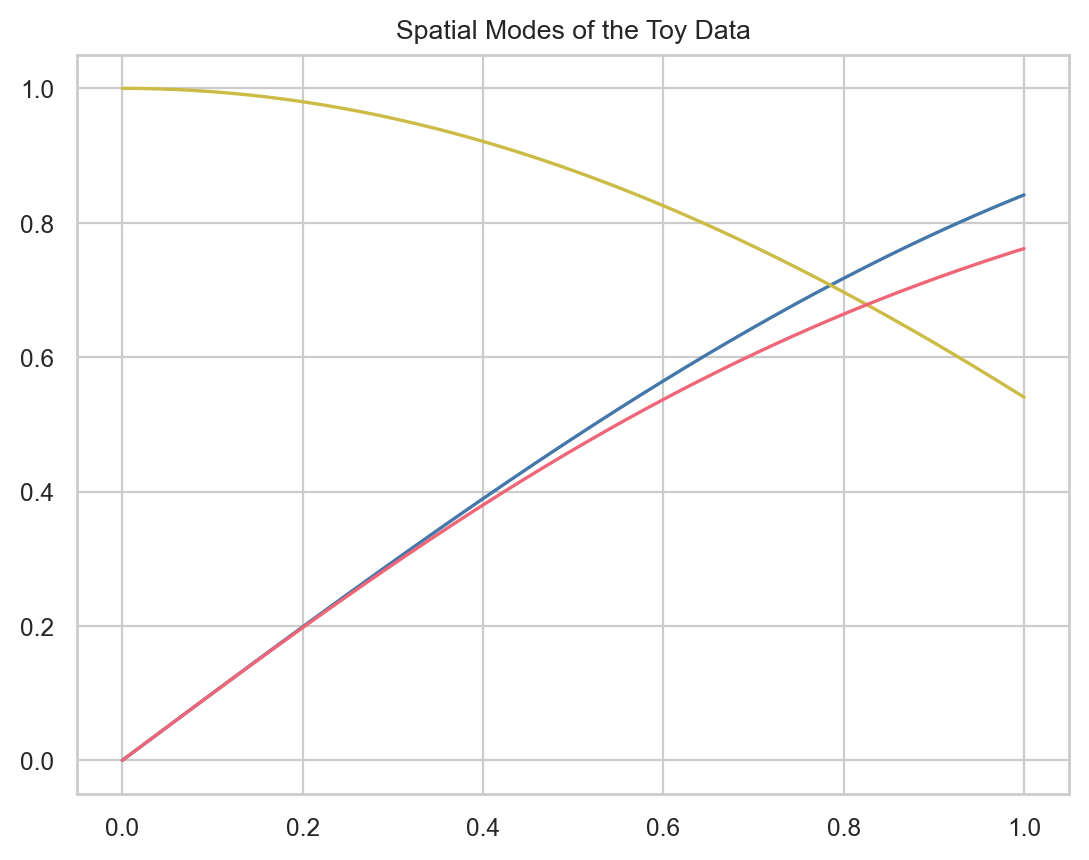

In [12]:
fig, ax = plt.subplots(1, 1)
ax.plot(xspace, f1)
ax.plot(xspace, f2)
ax.plot(xspace, f3)
ax.set_title('Spatial Modes of the Toy Data')

In [13]:
# Number of time points
n = len(ts)

# Number of points to select for each ensemble.
ensemble_size = 50
# Number of noisy realizations to generate.
num_noise_cycles = 10
# Number of ensemble members for each noise realization.
num_ensembles =  25

# Select a much larger noise level than in the paper to better illustrate
# improved ensemble selection strategies.
# sigma_array = [1e-1, 1e-2, 1e-3]
sigma_array = [0.5, 0.1]

verbose = False

### Fit and Visualize

In [14]:
ds_optdmd, ds_bopdmd, optdmd_container, bopdmd_container = run_noisy_realizations(
    xclean_exp_growth, ts, sigma_array, num_noise_cycles, num_ensembles,
    ensemble_size, true_eigenvalues_g, seed=1, ts_forecast=ts_forecast, data_forecast=xclean_forecast) 

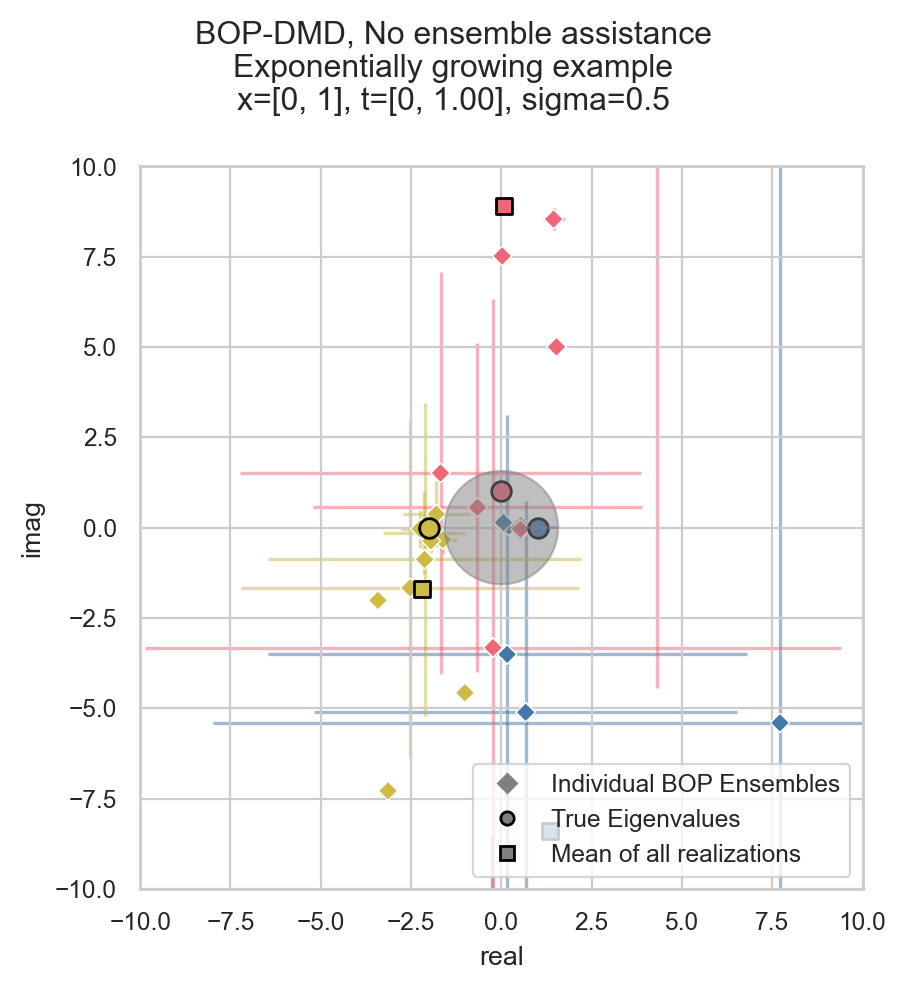

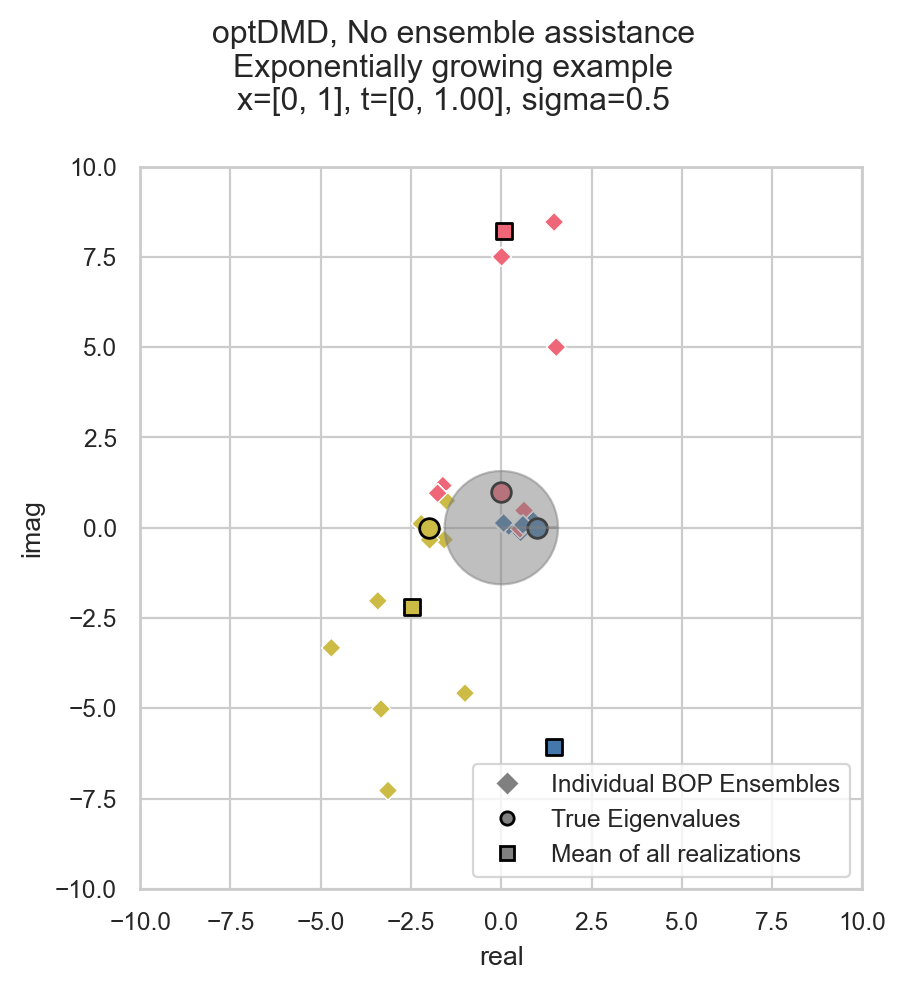

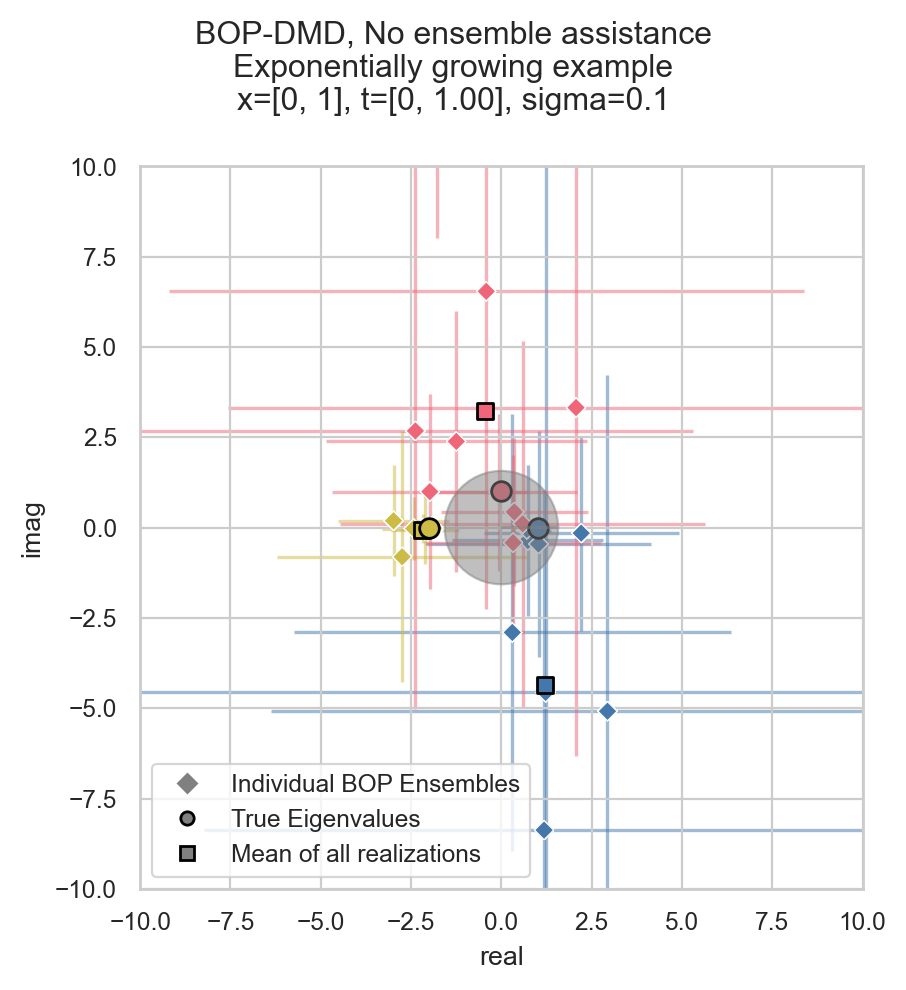

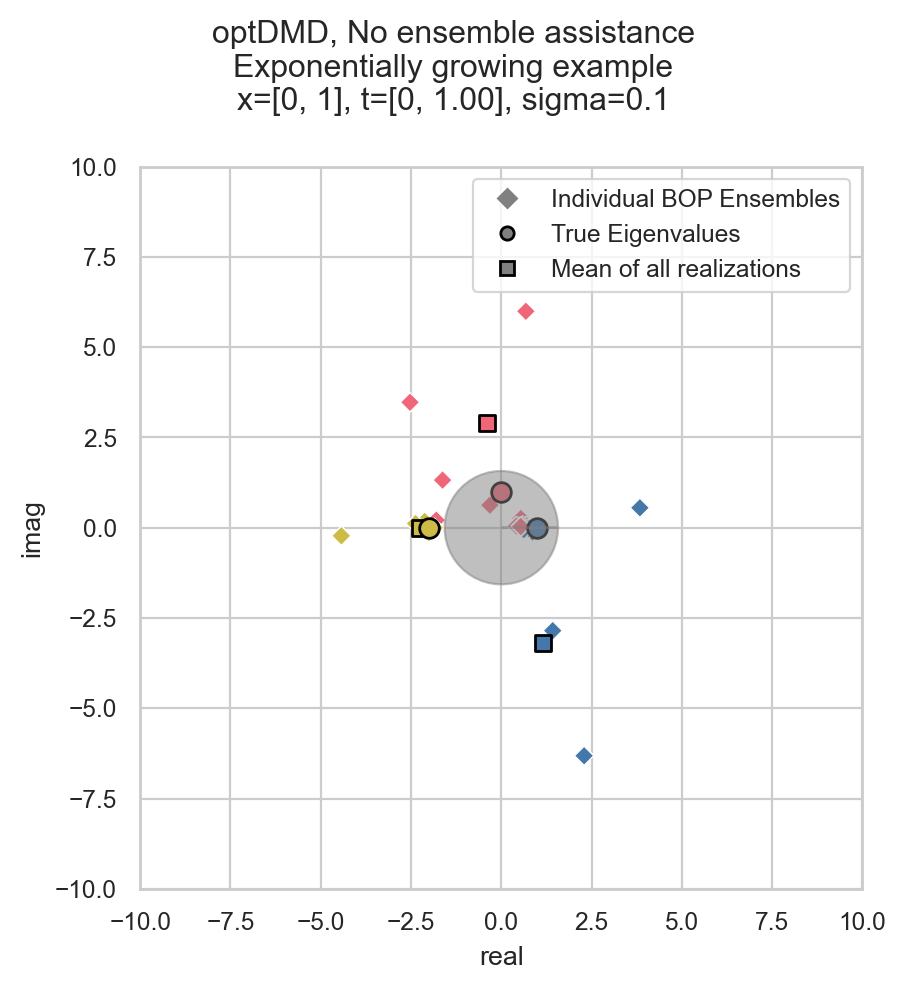

In [15]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
radii = [0, np.pi / (2 * t1)]
xs, ys = certainty_donut(radii)

for sigma in ds_bopdmd.sigma:
    plt.figure(figsize=(5, 5))
    g = eigenvalue_scatterplot(ds_bopdmd.sel(sigma=sigma), true_eigenvalues_g, lims=(-10, 10))
    plt.gcf().suptitle("BOP-DMD, No ensemble assistance\nExponentially growing example\nx=[0, {}], t=[0, {:1.2f}], sigma={}".format(x1, t1, sigma.values))
    plt.gcf().tight_layout()
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)
    
    plt.figure(figsize=(5, 5))
    g = eigenvalue_scatterplot(ds_optdmd.sel(sigma=sigma), true_eigenvalues_g, lims=(-10, 10))
    plt.gcf().suptitle("optDMD, No ensemble assistance\nExponentially growing example\nx=[0, {}], t=[0, {:1.2f}], sigma={}".format(x1, t1, sigma.values))
    plt.gcf().tight_layout()
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)


(0.0, 1.0)

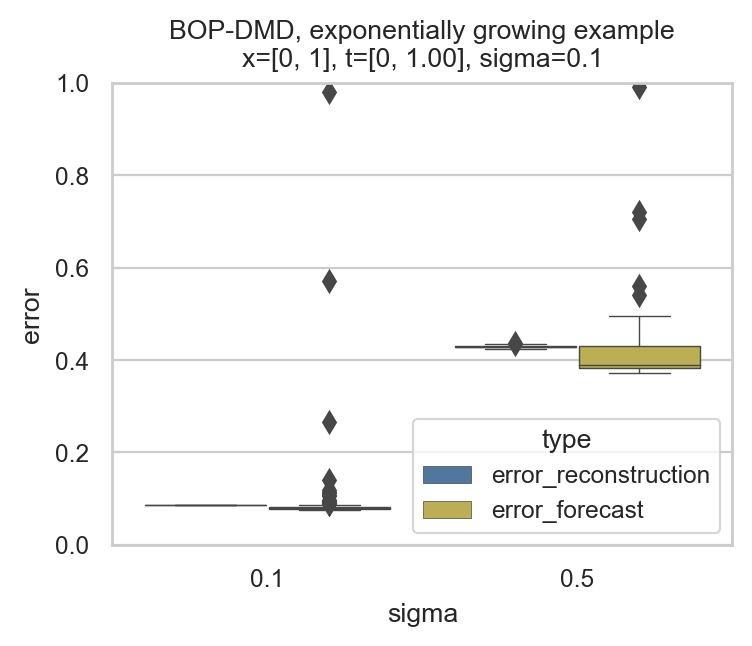

In [16]:
df = ds_bopdmd[['error_reconstruction', 'error_forecast']].to_dataframe().reset_index()
df = pd.melt(df, value_vars=['error_reconstruction', 'error_forecast'], value_name='error', var_name='type', id_vars='sigma')
fig, ax = plt.subplots(1, 1, figsize=(4, 3,))
g = sns.boxplot(data=df, x='sigma', y='error', hue='type', linewidth=0.5, ax=ax)
g.set_title("BOP-DMD, exponentially growing example\nx=[0, {}], t=[0, {:1.2f}], sigma={}".format(x1, t1, sigma.values))
g.set_ylim(0, 1)

(0.0, 1.0)

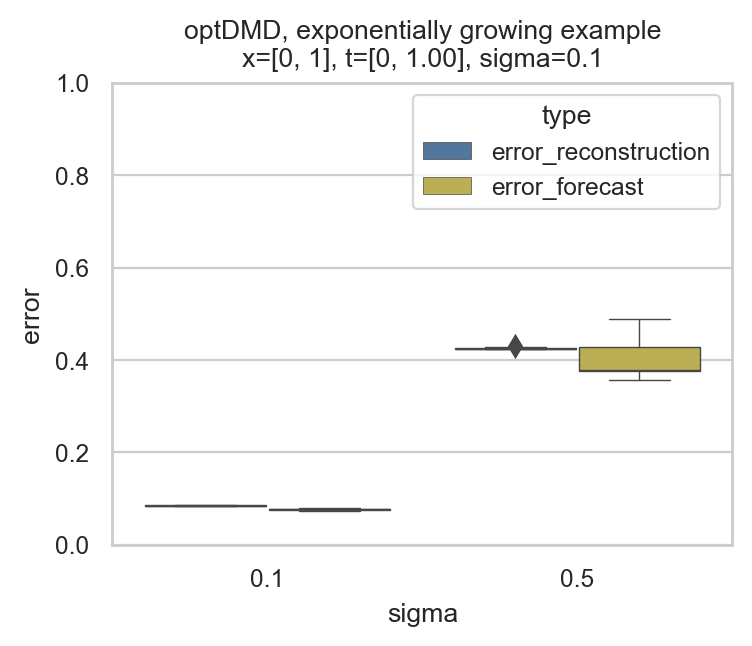

In [17]:
df = ds_optdmd[['error_reconstruction', 'error_forecast']].to_dataframe().reset_index()
df = pd.melt(df, value_vars=['error_reconstruction', 'error_forecast'], value_name='error', var_name='type', id_vars='sigma')

fig, ax = plt.subplots(1, 1, figsize=(4, 3,))
g = sns.boxplot(data=df, x='sigma', y='error', hue='type', linewidth=0.5, ax=ax)
g.set_title("optDMD, exponentially growing example\nx=[0, {}], t=[0, {:1.2f}], sigma={}".format(x1, t1, sigma.values))
g.set_ylim(0, 1)

### Ensemble pruning

(0.0, 1.0)

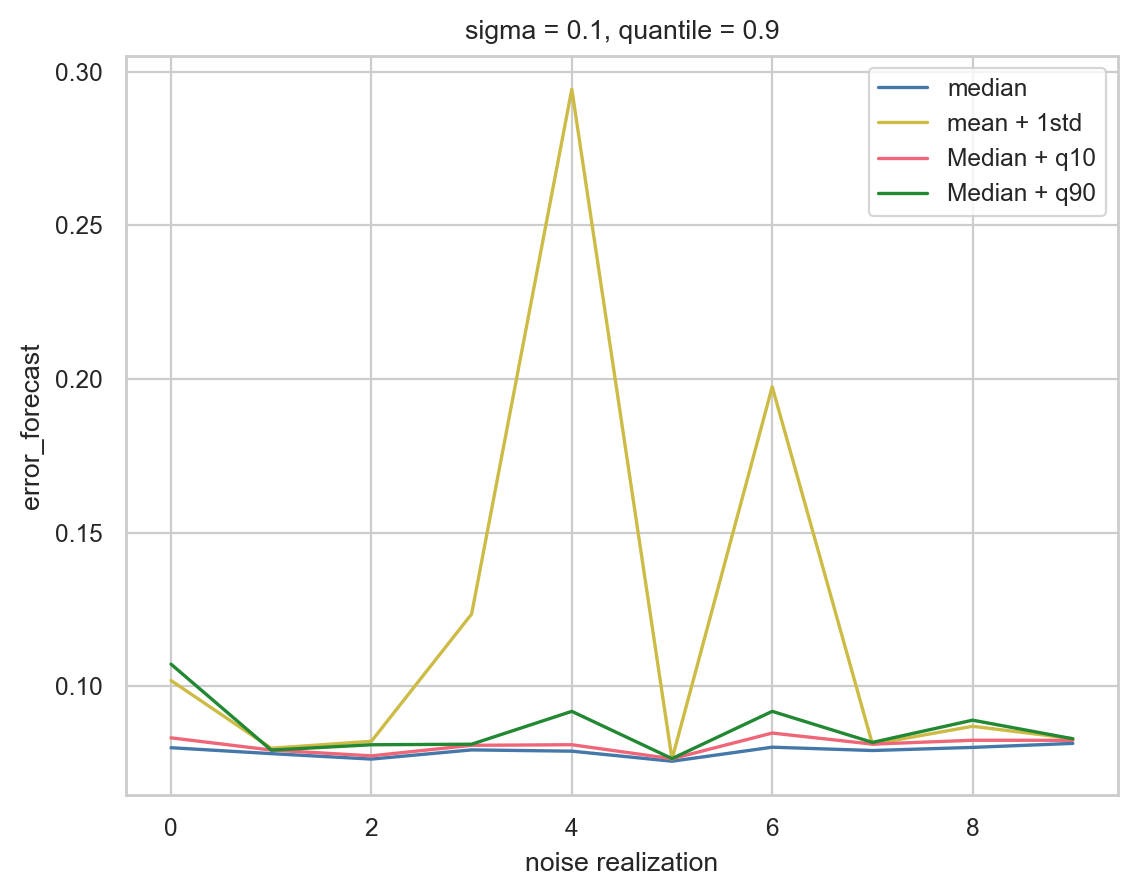

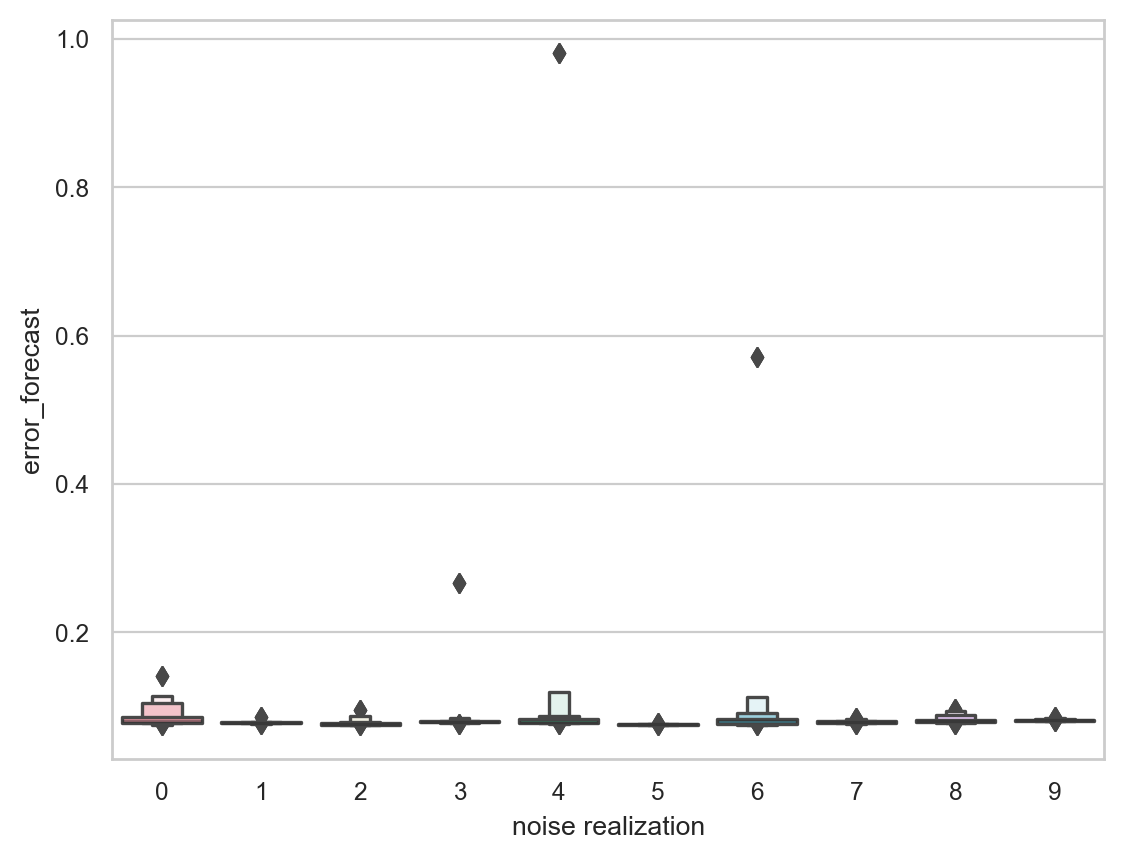

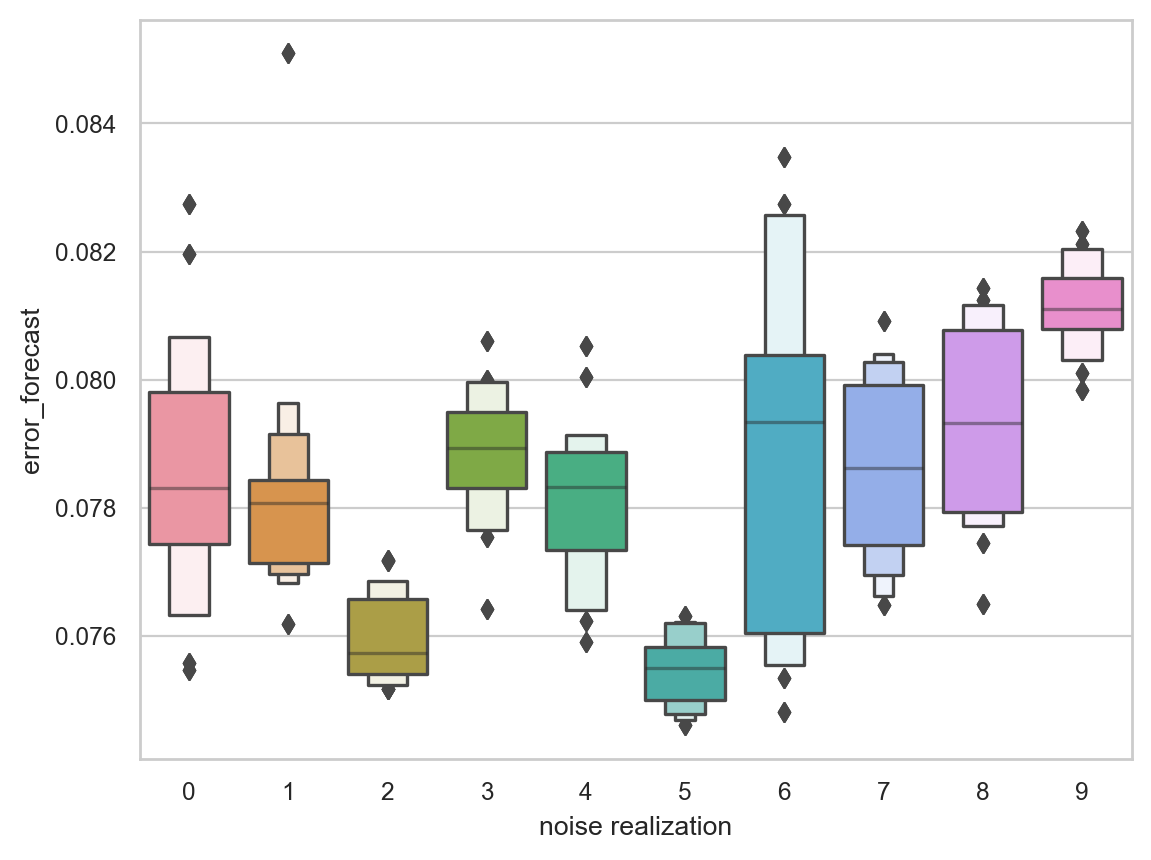

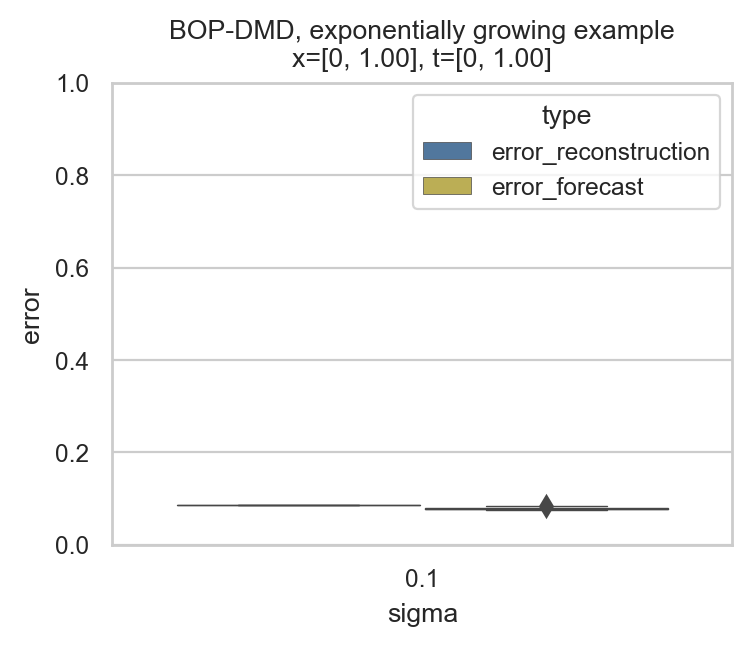

In [18]:
ds = ds_bopdmd.sel(sigma=0.1)

plt.figure()
ds.error_forecast.median(dim='_member').plot(label='median')
(ds.error_forecast.mean(dim='_member') + ds.error_forecast.std(dim='_member')).plot(label='mean + 1std')
inner_quartile_range = ds.error_forecast.quantile(0.75, dim='_member') - ds.error_forecast.quantile(0.25, dim='_member')
q90 = np.abs(ds.error_forecast.median(dim='_member') - ds.error_forecast.quantile(0.9, dim='_member'))
q10 = np.abs(ds.error_forecast.median(dim='_member') - ds.error_forecast.quantile(0.1, dim='_member'))
(ds.error_forecast.median(dim='_member') + q10).plot(label='Median + q10')
(ds.error_forecast.median(dim='_member') + q90).plot(label='Median + q90')
plt.gca().legend()

q10_range = np.abs(ds.error_forecast.median(dim='_member') - ds.error_forecast.quantile(0.1, dim='_member'))
q90_range = np.abs(ds.error_forecast.median(dim='_member') - ds.error_forecast.quantile(0.9, dim='_member'))
long_tail = q90_range - q10_range > 0
outlier_range = ds.error_forecast.median(dim='_member') + q10_range
ds1 = xr.where(long_tail, ds.where((ds.error_forecast < outlier_range)), ds)

plt.figure()
sns.boxenplot(data=ds.to_dataframe().reset_index(), x='noise realization', y='error_forecast')

plt.figure()
sns.boxenplot(data=ds1.to_dataframe().reset_index(), x='noise realization', y='error_forecast')

df = ds1[['error_reconstruction', 'error_forecast']].to_dataframe().reset_index()
df = pd.melt(df, value_vars=['error_reconstruction', 'error_forecast'], value_name='error', var_name='type', id_vars='sigma')
fig, ax = plt.subplots(1, 1, figsize=(4, 3,))
g = sns.boxplot(data=df, x='sigma', y='error', hue='type', linewidth=0.5, ax=ax)
g.set_title("BOP-DMD, exponentially growing example\nx=[0, {:1.2f}], t=[0, {:1.2f}]".format(x1, t1))
g.set_ylim(0, 1)

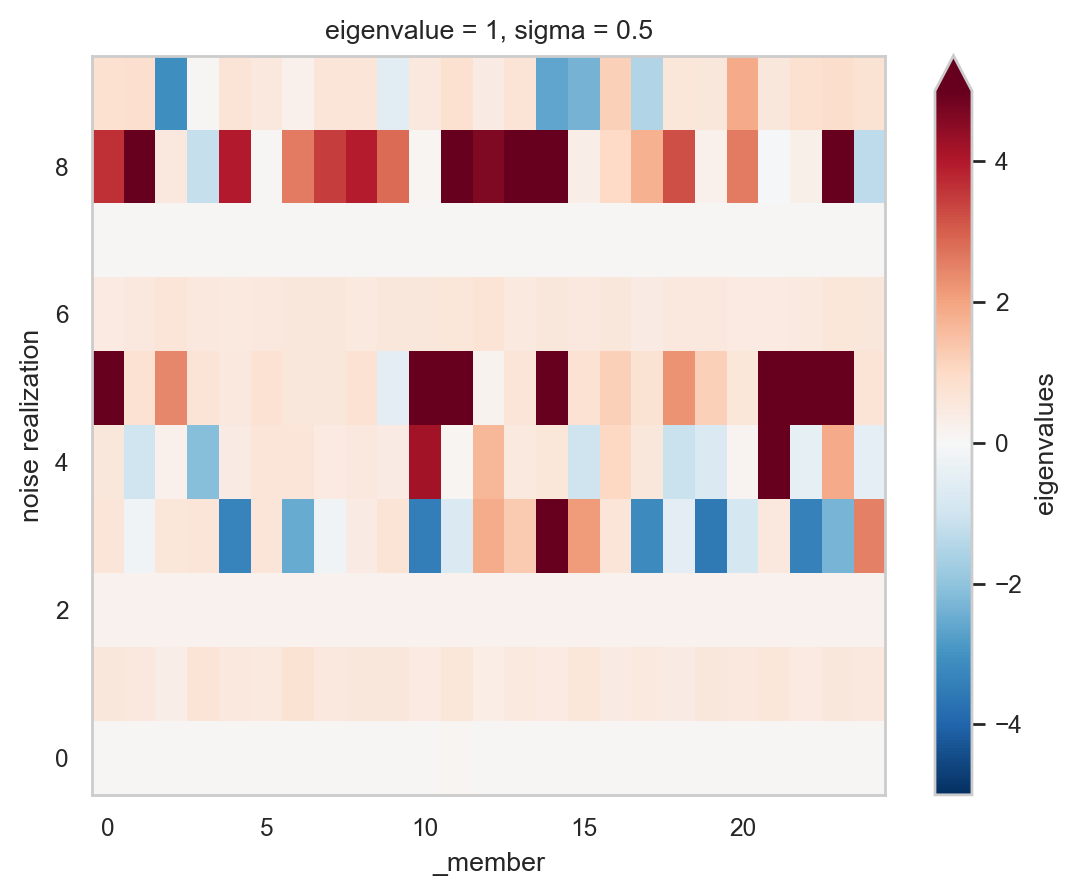

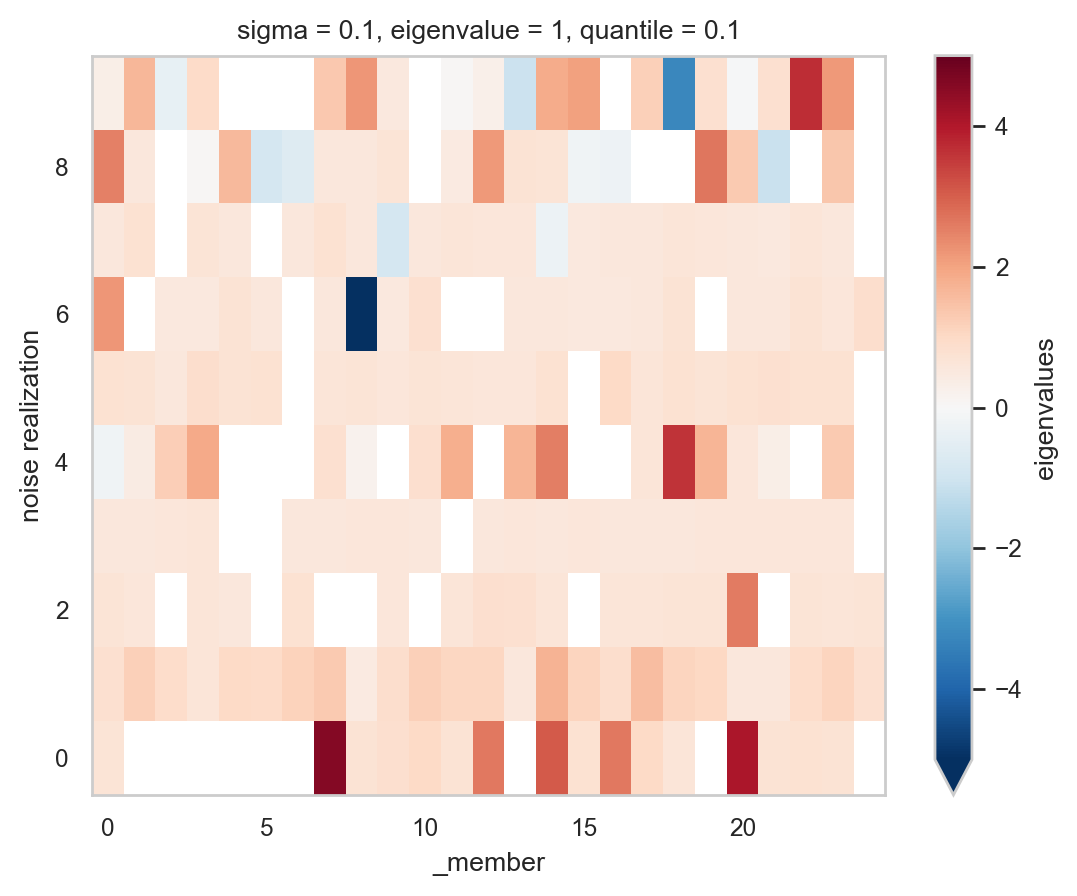

In [19]:
ds_eig = ds_bopdmd.sel(eigenvalue='1', sigma=0.5)
np.real(ds_eig.eigenvalues).plot(vmin=-5, vmax=5, cmap='RdBu_r')

plt.figure()
ds_eig = ds1.sel(eigenvalue='1')
np.real(ds_eig.eigenvalues).plot(vmin=-5, vmax=5, cmap='RdBu_r')

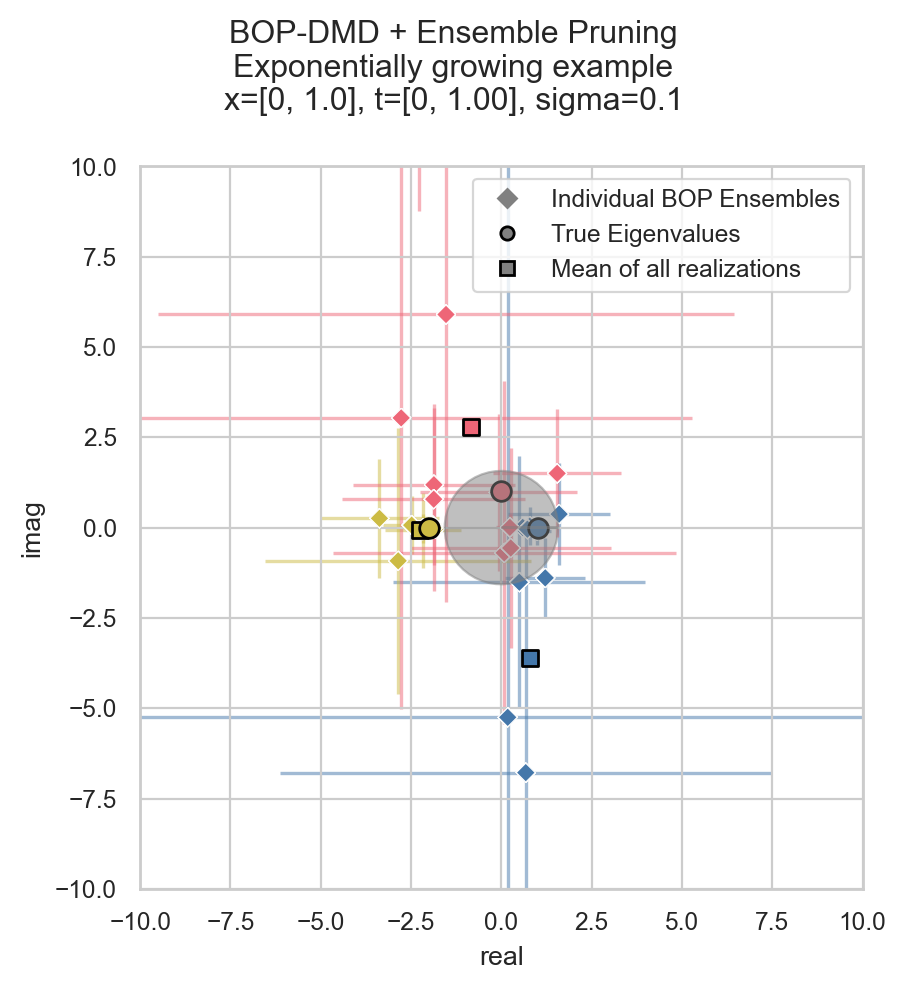

In [20]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
radii = [0, np.pi / (2 * t1)]
xs, ys = certainty_donut(radii)

ds1['real'] = np.real(ds1.eigenvalues.mean(dim='_member'))
ds1['imag'] = np.imag(ds1.eigenvalues.mean(dim='_member'))
ds1['real_std'] = ds1.eigenvalues.std(dim='_member')
ds1.coords['sigma'] = 0.1

plt.figure(figsize=(5, 5))
g = eigenvalue_scatterplot(ds1, true_eigenvalues_g, lims=(-10, 10))
plt.gcf().suptitle(
    "BOP-DMD + Ensemble Pruning\nExponentially growing example\nx=[0, {:1.2}], t=[0, {:1.2f}], sigma={}".format(float(x1), t1, 0.1))
plt.gcf().tight_layout()
g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)



Text(0.5, 1.0, 'white noise, sigma=0.5')

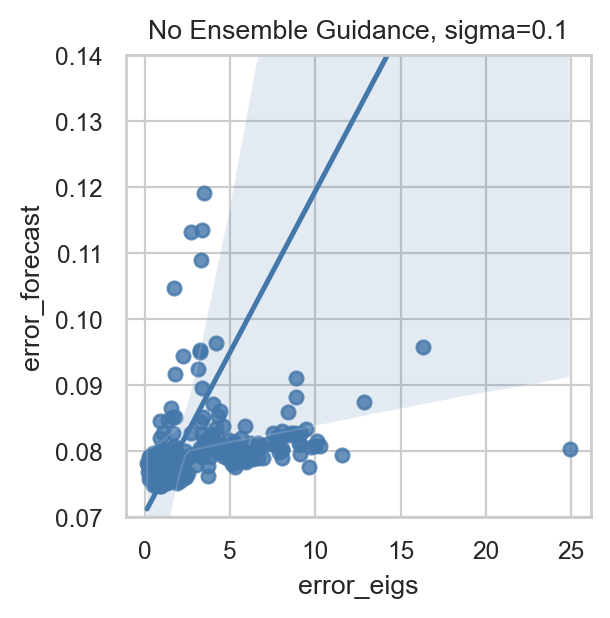

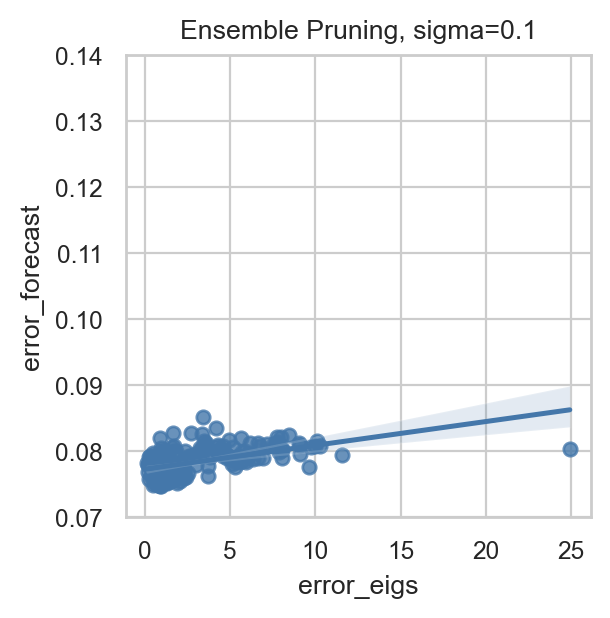

<Figure size 640x480 with 0 Axes>

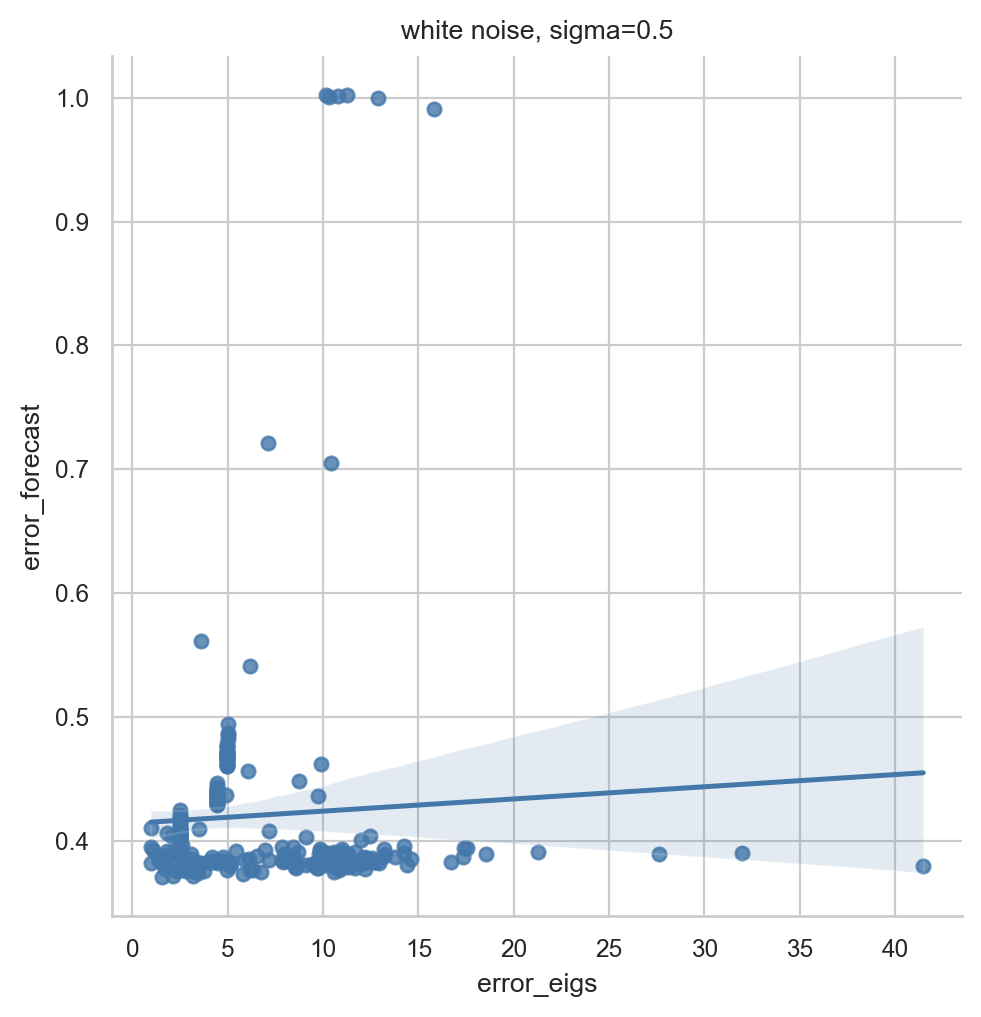

In [21]:
plt.figure(figsize=(3, 3))
sns.regplot(data=ds_bopdmd.mean(dim='eigenvalue').sel(sigma=0.1).to_dataframe().reset_index(), x='error_eigs', y='error_forecast', ax=plt.gca())
plt.gca().set_title('No Ensemble Guidance, sigma=0.1')
plt.gca().set_ylim(0.07, 0.14)

plt.figure(figsize=(3, 3))
sns.regplot(data=ds1.mean(dim='eigenvalue').to_dataframe().reset_index(), x='error_eigs', y='error_forecast', ax=plt.gca())
plt.gca().set_title('Ensemble Pruning, sigma=0.1')
plt.gca().set_ylim(0.07, 0.14)

plt.figure()
sns.lmplot(data=ds_bopdmd.mean(dim='eigenvalue').sel(sigma=0.5).to_dataframe().reset_index(), x='error_eigs', y='error_forecast')
plt.gca().set_title('white noise, sigma=0.5')

## Expanded spatial domain

Include more spatial oscillations

### Generate spatial modes on a larger domain

In [22]:
# Generate the synthetic data.

# Set up modes in space.
x0 = 0
x1 = np.pi
nx = 200

# Space component is evenly spaced originally.
xspace = np.linspace(x0,x1,nx)

# Set up the spatial modes
f1 = np.sin(xspace)[:, np.newaxis]
f2 = np.cos(xspace)[:, np.newaxis]
f3 = np.tanh(xspace)[:, np.newaxis]

# Set up the time dynamics.
t0 = 0
t1 = 1
t_extended = 5
nt = 100
ts = np.linspace(t0,t1,nt)[np.newaxis, :]
ts_extended = np.linspace(t0, t_extended, t_extended * nt)[np.newaxis, :]

# Eigenvalues for each mode
e1_g = 1 + 0j
e2_g = -2 + 0j
e3_g = 0 + 1j
true_eigenvalues_g = np.array([e1_g, e2_g, e3_g])

# Generate the clean, noiseless dynamics.
xclean_exp_growth = simple_example([f1, f2, f3], true_eigenvalues_g, ts)

# Forecast verification
t2 = t1 + t1 * 0.1
ts_forecast = np.linspace(t1, t2, nt // 10, endpoint=False)[np.newaxis, :]
xclean_forecast = simple_example([f1, f2, f3], true_eigenvalues_g, ts_forecast)

Text(0, 0.5, 'Amplitude (-)')

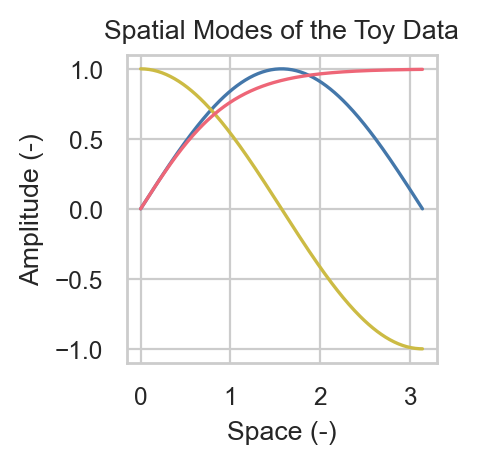

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2,))
ax.plot(xspace, f1)
ax.plot(xspace, f2)
ax.plot(xspace, f3)
ax.set_title('Spatial Modes of the Toy Data')
ax.set_xlabel('Space (-)')
ax.set_ylabel('Amplitude (-)')

### Fit

In [24]:
ds_optdmd, ds_bopdmd, optdmd_container, bopdmd_container = run_noisy_realizations(
    xclean_exp_growth, ts, sigma_array, num_noise_cycles, 50,
    ensemble_size, true_eigenvalues_g, seed=1, ts_forecast=ts_forecast, data_forecast=xclean_forecast) 

### Visualize

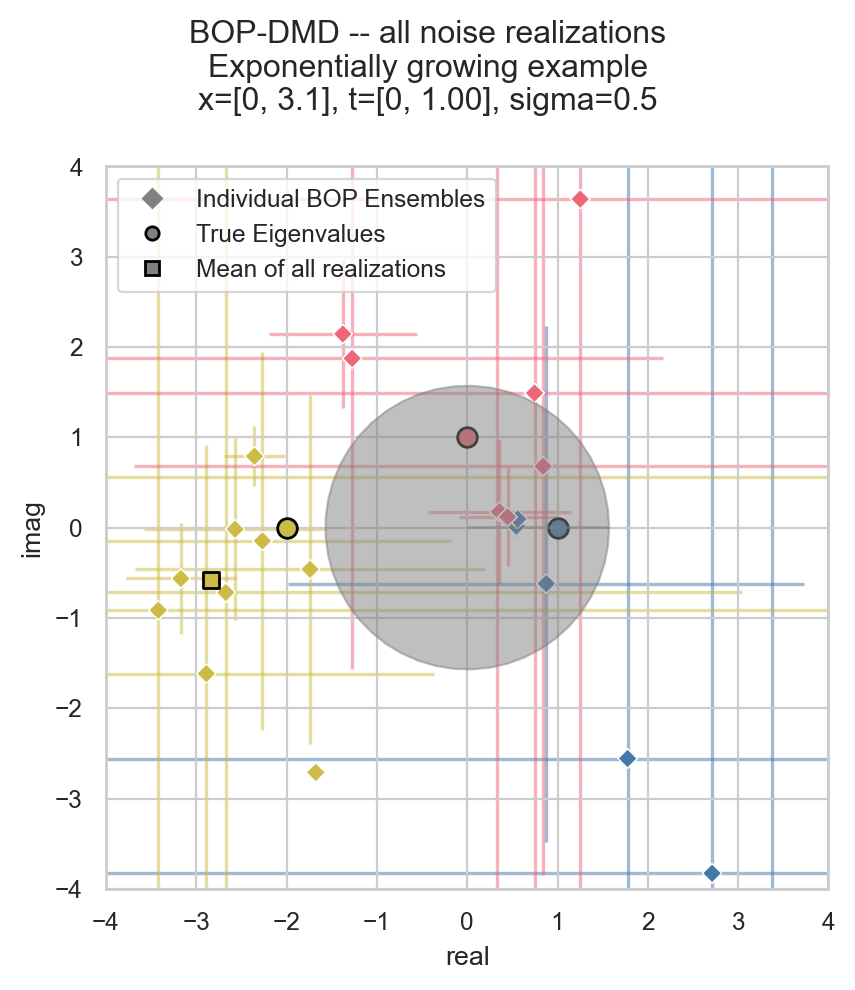

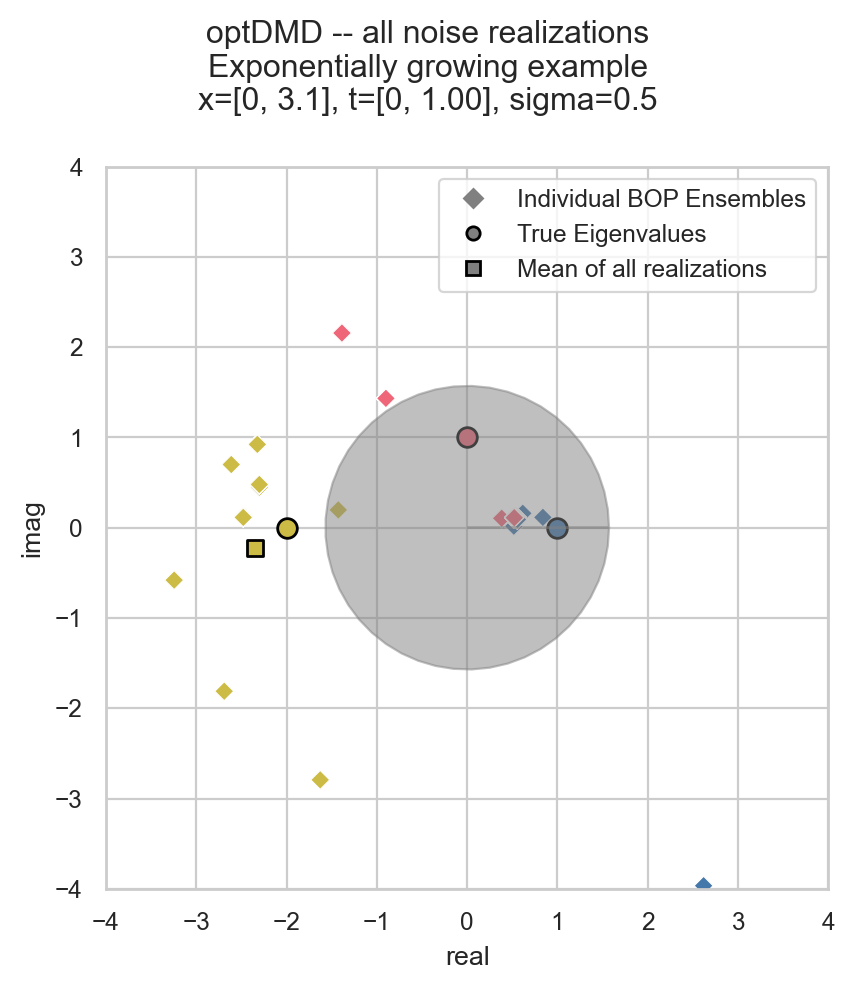

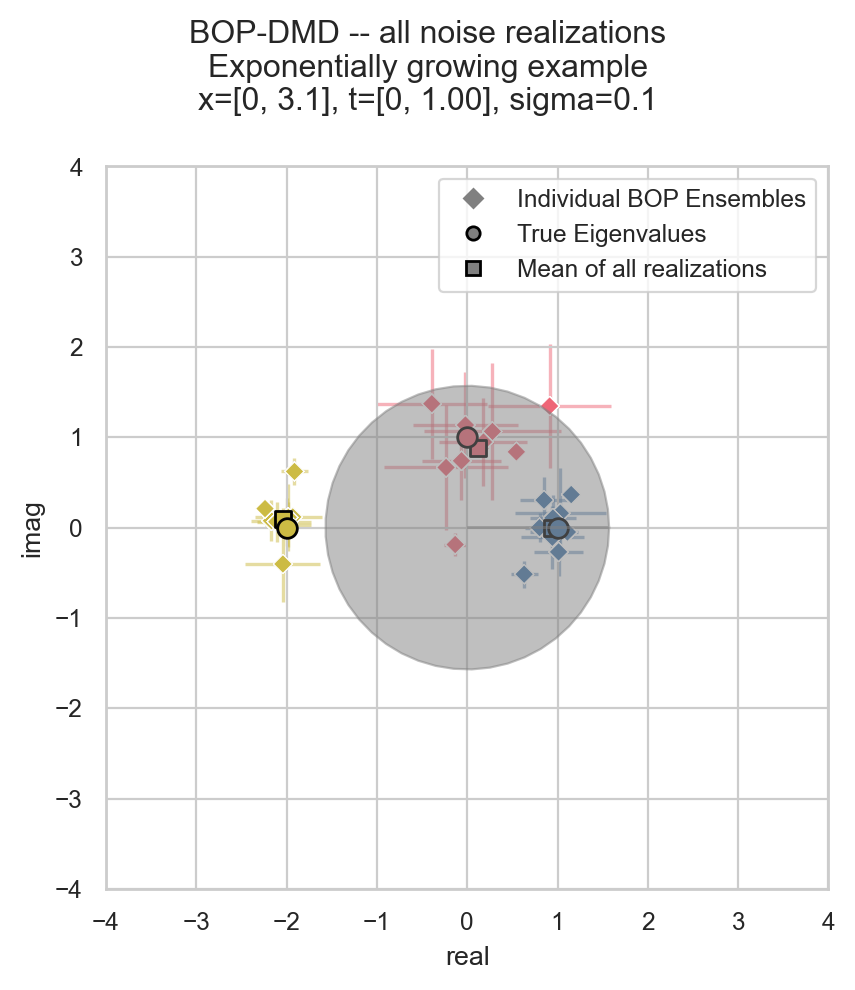

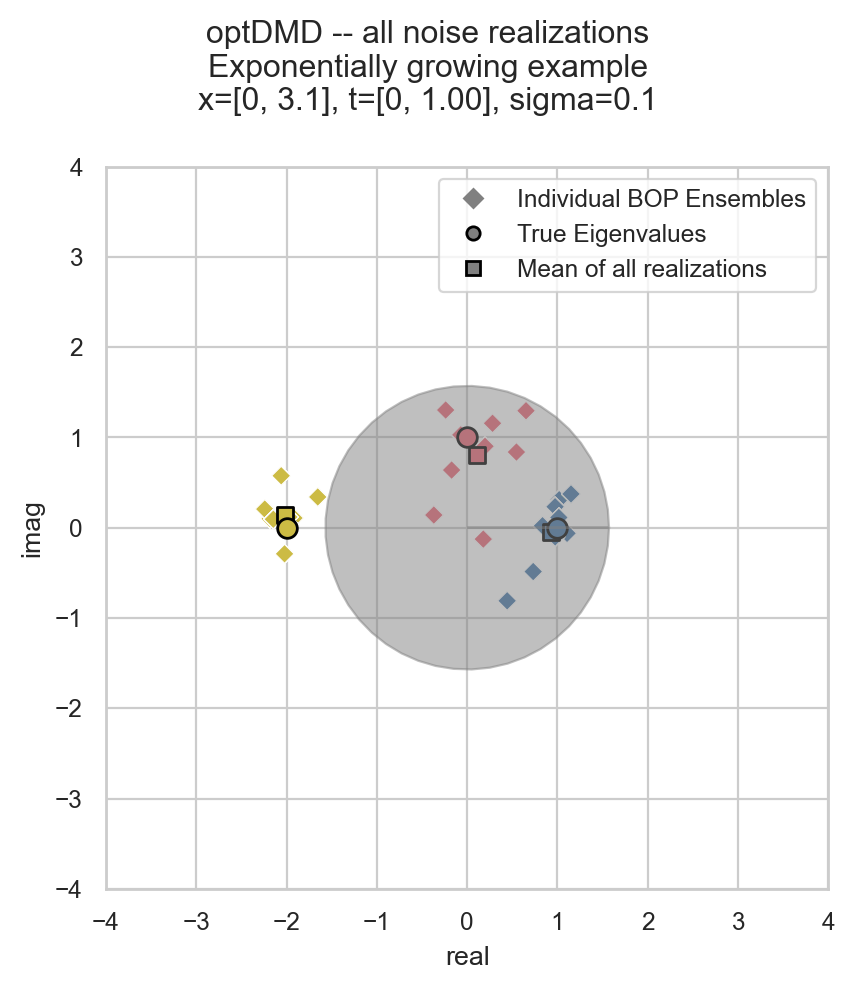

In [25]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
radii = [0, np.pi / (2 * t1)]
xs, ys = certainty_donut(radii)
for sigma in ds_bopdmd.sigma:
    plt.figure(figsize=(5, 5))
    g = eigenvalue_scatterplot(ds_bopdmd.sel(sigma=sigma), true_eigenvalues_g, lims=(-4, 4))
    plt.gcf().suptitle(
        "BOP-DMD -- all noise realizations\nExponentially growing example\nx=[0, {:1.2}], t=[0, {:1.2f}], sigma={}".format(x1, t1, sigma.values))
    plt.gcf().tight_layout()
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)

    plt.figure(figsize=(5, 5))
    g = eigenvalue_scatterplot(ds_optdmd.sel(sigma=sigma), true_eigenvalues_g, lims=(-4, 4))
    plt.gcf().suptitle(
        "optDMD -- all noise realizations\nExponentially growing example\nx=[0, {:1.2}], t=[0, {:1.2f}], sigma={}".format(x1, t1, sigma.values))
    plt.gcf().tight_layout()
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)


(0.0, 1.0)

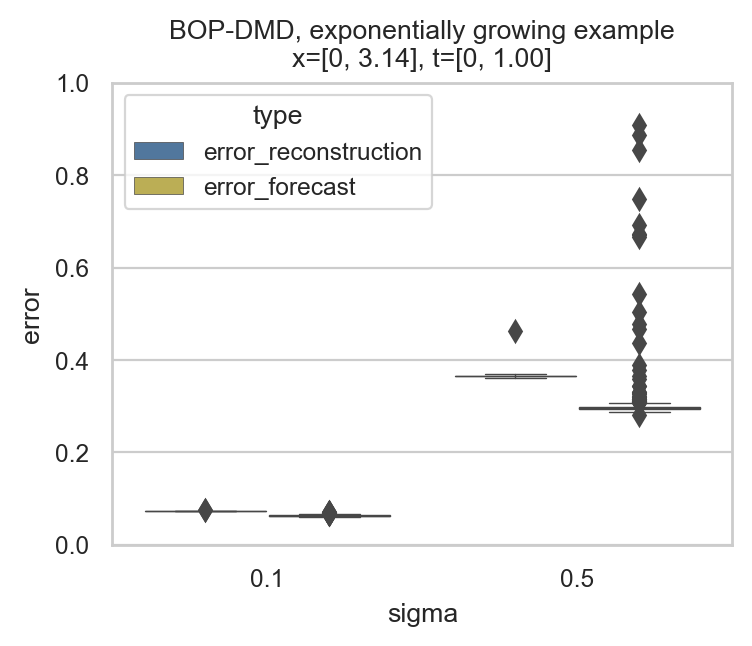

In [26]:
df = ds_bopdmd[['error_reconstruction', 'error_forecast']].to_dataframe().reset_index()
df = pd.melt(df, value_vars=['error_reconstruction', 'error_forecast'], value_name='error', var_name='type', id_vars='sigma')
fig, ax = plt.subplots(1, 1, figsize=(4, 3,))
g = sns.boxplot(data=df, x='sigma', y='error', hue='type', linewidth=0.5, ax=ax)
g.set_title("BOP-DMD, exponentially growing example\nx=[0, {:1.2f}], t=[0, {:1.2f}]".format(x1, t1))
g.set_ylim(0, 1)

(0.0, 1.0)

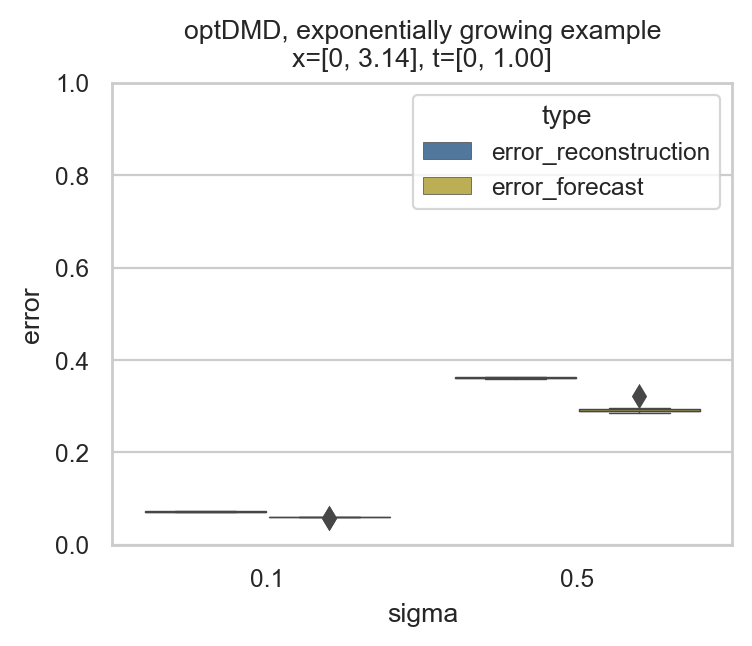

In [27]:
df = ds_optdmd[['error_reconstruction', 'error_forecast']].to_dataframe().reset_index()
df = pd.melt(df, value_vars=['error_reconstruction', 'error_forecast'], value_name='error', var_name='type', id_vars='sigma')
fig, ax = plt.subplots(1, 1, figsize=(4, 3,))
g = sns.boxplot(data=df, x='sigma', y='error', hue='type', linewidth=0.5, ax=ax)
g.set_title("optDMD, exponentially growing example\nx=[0, {:1.2f}], t=[0, {:1.2f}]".format(x1, t1))
g.set_ylim(0, 1)

### Ensemble Pruning

(0.0, 1.0)

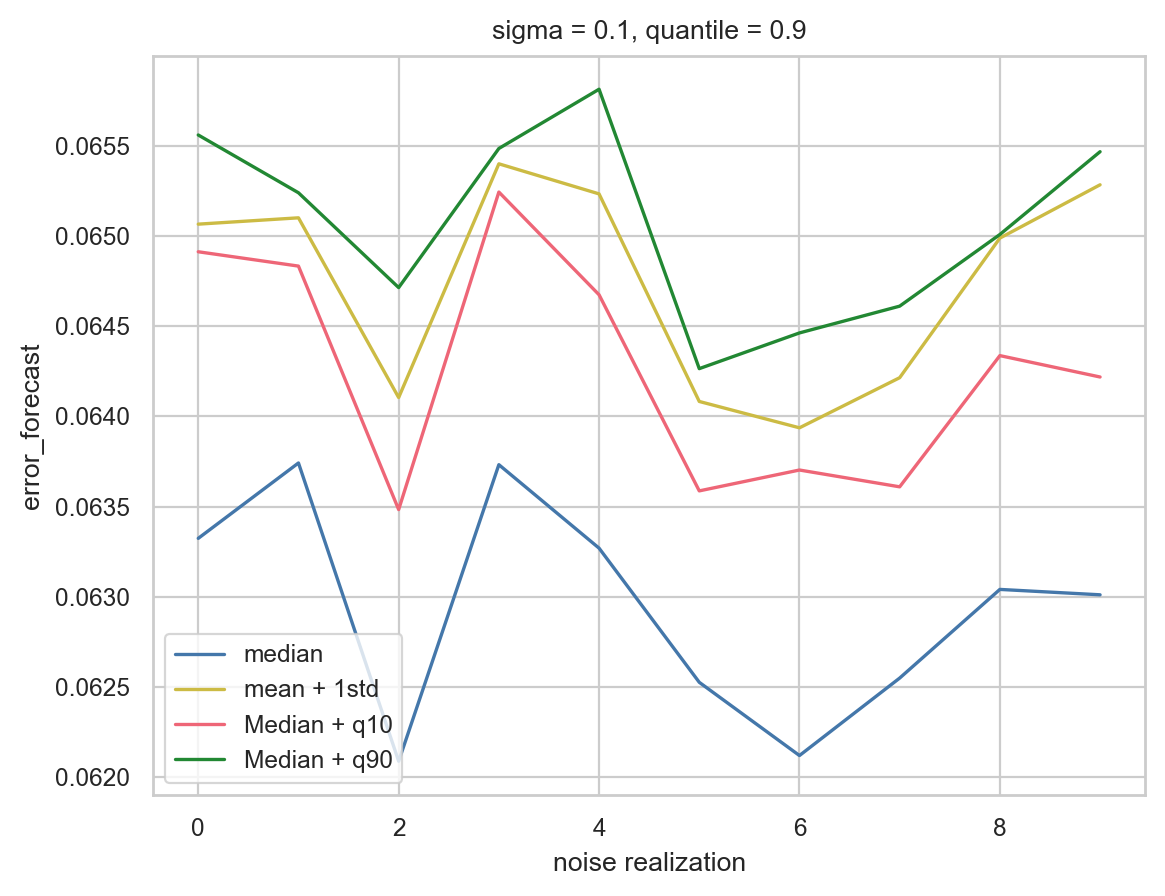

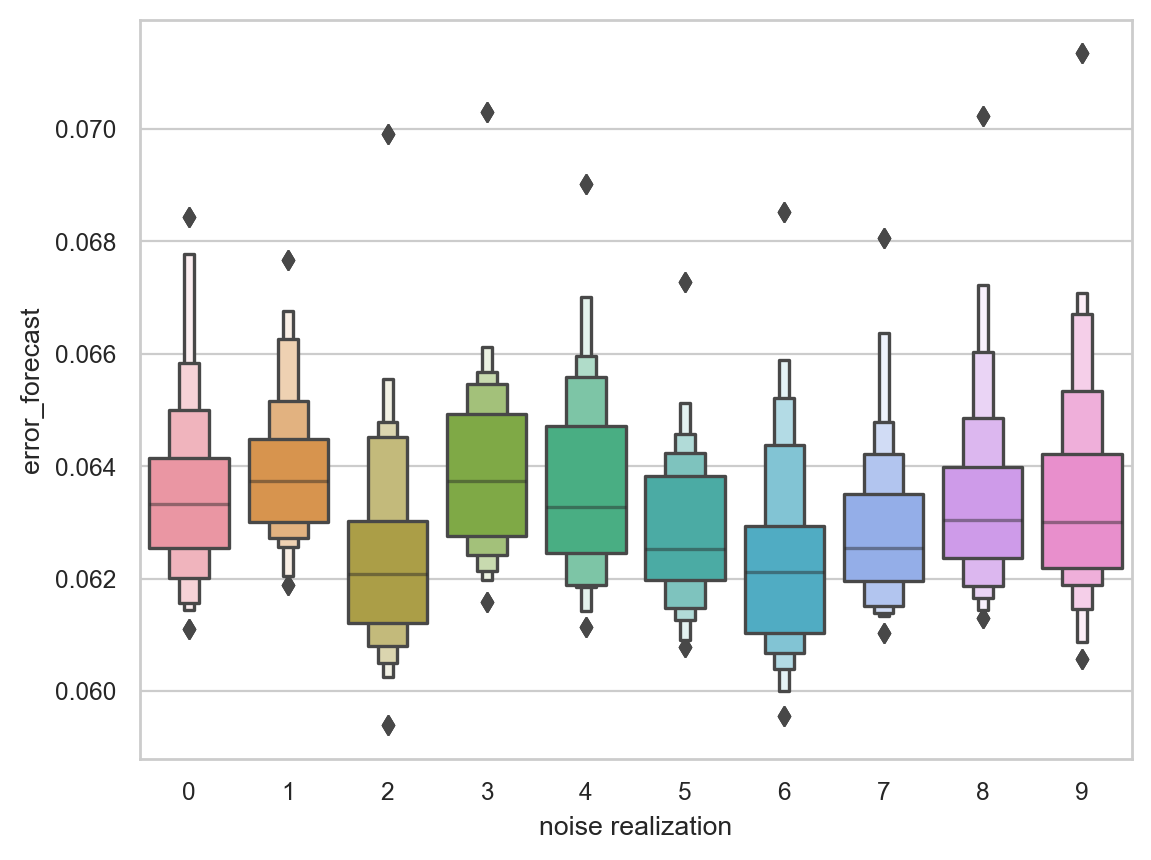

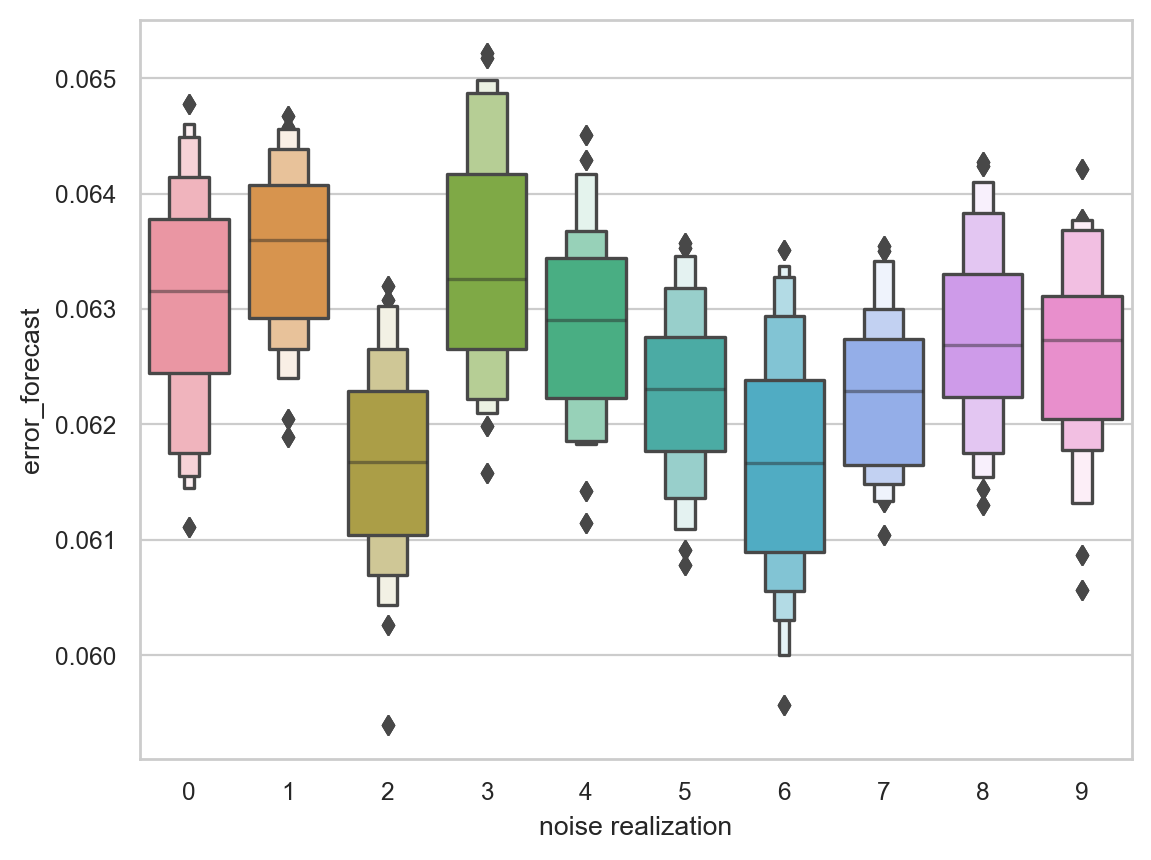

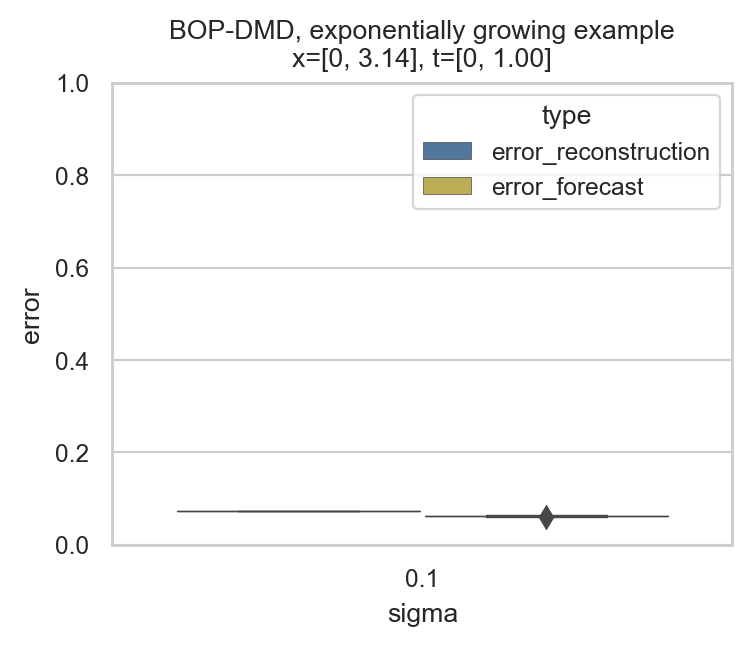

In [28]:
ds = ds_bopdmd.sel(sigma=0.1)

plt.figure()
ds.error_forecast.median(dim='_member').plot(label='median')
(ds.error_forecast.mean(dim='_member') + ds.error_forecast.std(dim='_member')).plot(label='mean + 1std')
inner_quartile_range = ds.error_forecast.quantile(0.75, dim='_member') - ds.error_forecast.quantile(0.25, dim='_member')
q90 = np.abs(ds.error_forecast.median(dim='_member') - ds.error_forecast.quantile(0.9, dim='_member'))
q10 = np.abs(ds.error_forecast.median(dim='_member') - ds.error_forecast.quantile(0.1, dim='_member'))
(ds.error_forecast.median(dim='_member') + q10).plot(label='Median + q10')
(ds.error_forecast.median(dim='_member') + q90).plot(label='Median + q90')
plt.gca().legend()
# plt.gca().set_ylim(0.28, 0.33)

q10_range = np.abs(ds.error_forecast.median(dim='_member') - ds.error_forecast.quantile(0.1, dim='_member'))
q90_range = np.abs(ds.error_forecast.median(dim='_member') - ds.error_forecast.quantile(0.9, dim='_member'))
long_tail = q90_range - q10_range > 0
outlier_range = ds.error_forecast.median(dim='_member') + q10_range
ds1 = xr.where(long_tail, ds.where((ds.error_forecast < outlier_range)), ds)

plt.figure()
sns.boxenplot(data=ds.to_dataframe().reset_index(), x='noise realization', y='error_forecast')
# plt.gca().set_ylim(0.2, 0.5)

plt.figure()
sns.boxenplot(data=ds1.to_dataframe().reset_index(), x='noise realization', y='error_forecast')
# plt.gca().set_ylim(0.2, 0.5)

df = ds1[['error_reconstruction', 'error_forecast']].to_dataframe().reset_index()
df = pd.melt(df, value_vars=['error_reconstruction', 'error_forecast'], value_name='error', var_name='type', id_vars='sigma')
fig, ax = plt.subplots(1, 1, figsize=(4, 3,))
g = sns.boxplot(data=df, x='sigma', y='error', hue='type', linewidth=0.5, ax=ax)
g.set_title("BOP-DMD, exponentially growing example\nx=[0, {:1.2f}], t=[0, {:1.2f}]".format(x1, t1))
g.set_ylim(0, 1)

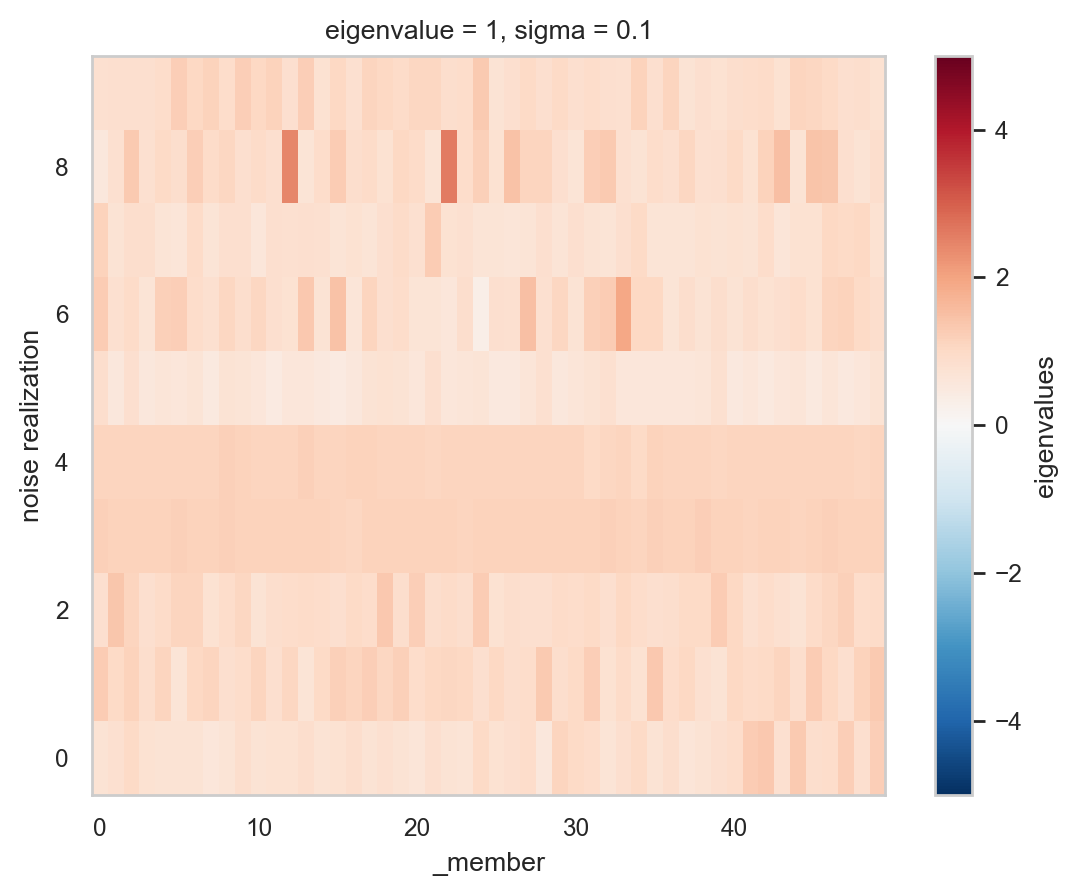

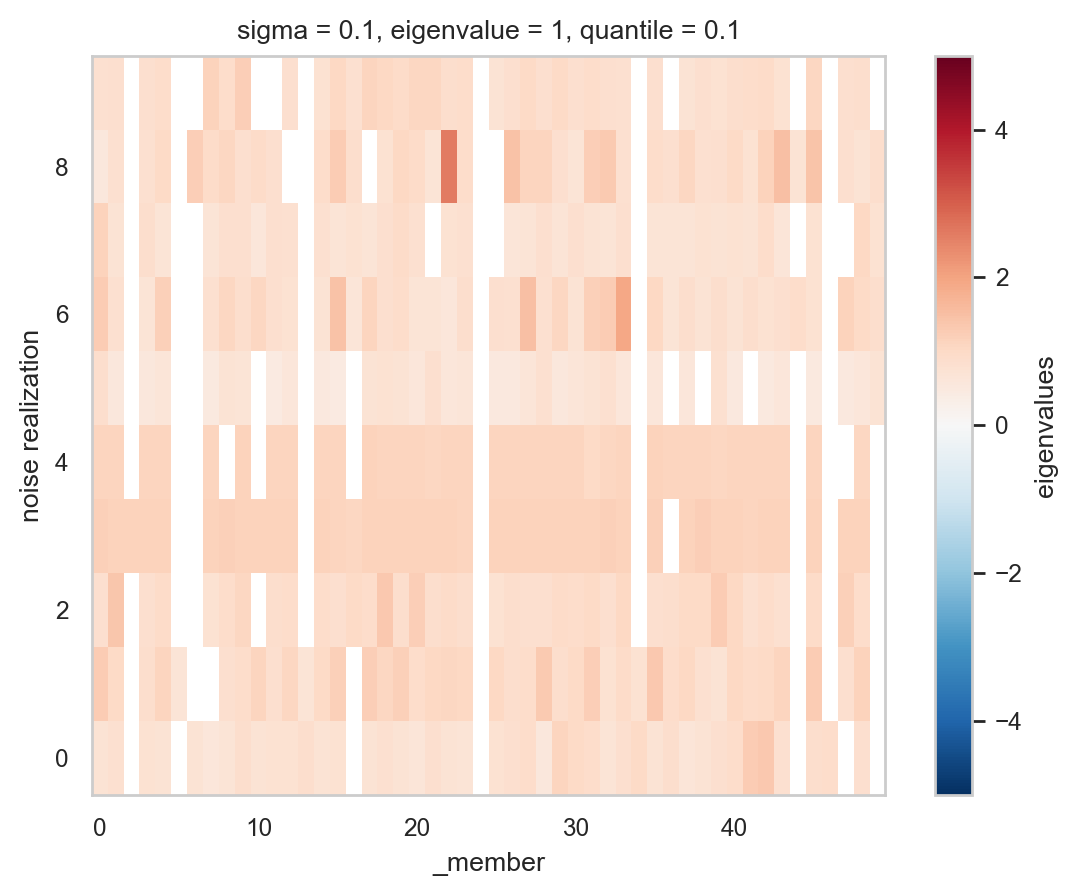

In [29]:
ds_eig = ds_bopdmd.sel(eigenvalue='1', sigma=0.1)
np.real(ds_eig.eigenvalues).plot(vmin=-5, vmax=5, cmap='RdBu_r')

plt.figure()
ds_eig = ds1.sel(eigenvalue='1')
np.real(ds_eig.eigenvalues).plot(vmin=-5, vmax=5, cmap='RdBu_r')

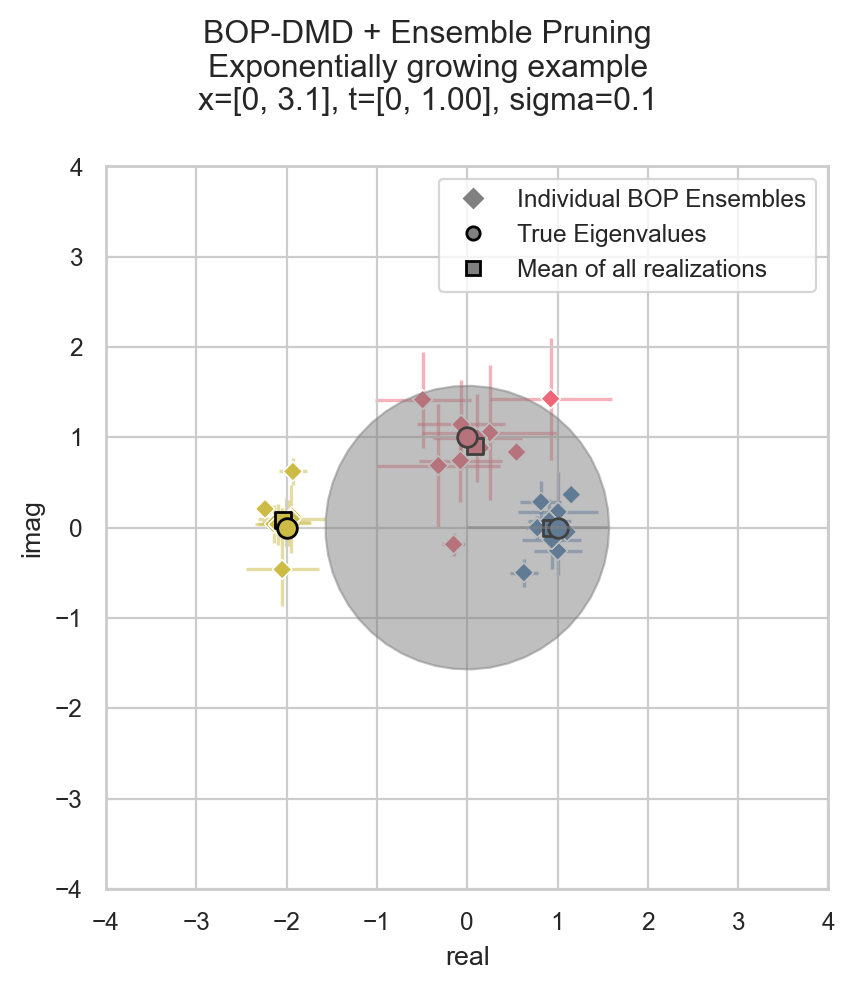

In [30]:
ds1['real'] = np.real(ds1.eigenvalues.mean(dim='_member'))
ds1['imag'] = np.imag(ds1.eigenvalues.mean(dim='_member'))
ds1['real_std'] = ds1.eigenvalues.std(dim='_member')

# Distribution plots for the BOP-DMD and optDMD eigenvalues.
radii = [0, np.pi / (2 * t1)]
xs, ys = certainty_donut(radii)

ds1['real'] = np.real(ds1.eigenvalues.mean(dim='_member'))
ds1['imag'] = np.imag(ds1.eigenvalues.mean(dim='_member'))
ds1['real_std'] = ds1.eigenvalues.std(dim='_member')
ds1.coords['sigma'] = 0.5

plt.figure(figsize=(5, 5))
g = eigenvalue_scatterplot(ds1, true_eigenvalues_g, lims=(-4, 4))
plt.gcf().suptitle(
    "BOP-DMD + Ensemble Pruning\nExponentially growing example\nx=[0, {:1.2}], t=[0, {:1.2f}], sigma={}".format(float(x1), t1, 0.1))
plt.gcf().tight_layout()
g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)



Text(0.5, 1.0, 'white noise, sigma=0.5')

<Figure size 640x480 with 0 Axes>

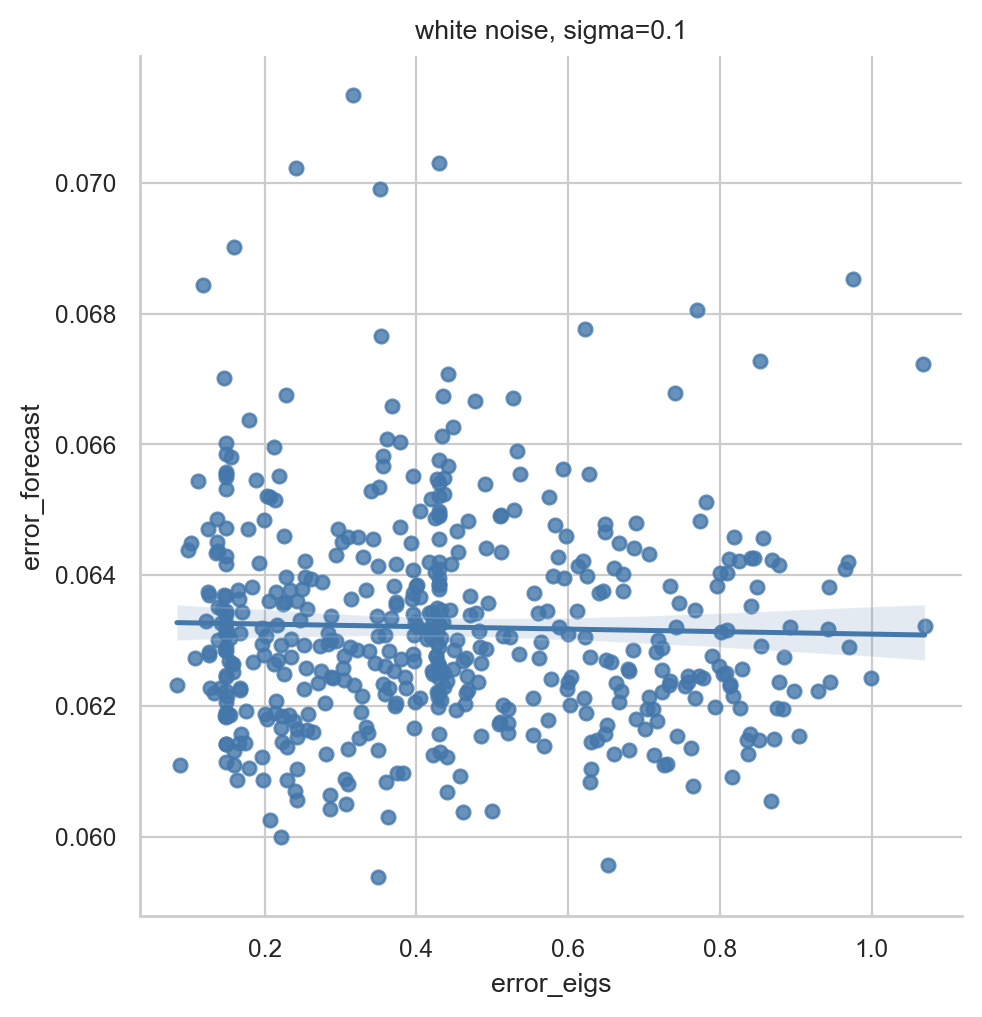

<Figure size 640x480 with 0 Axes>

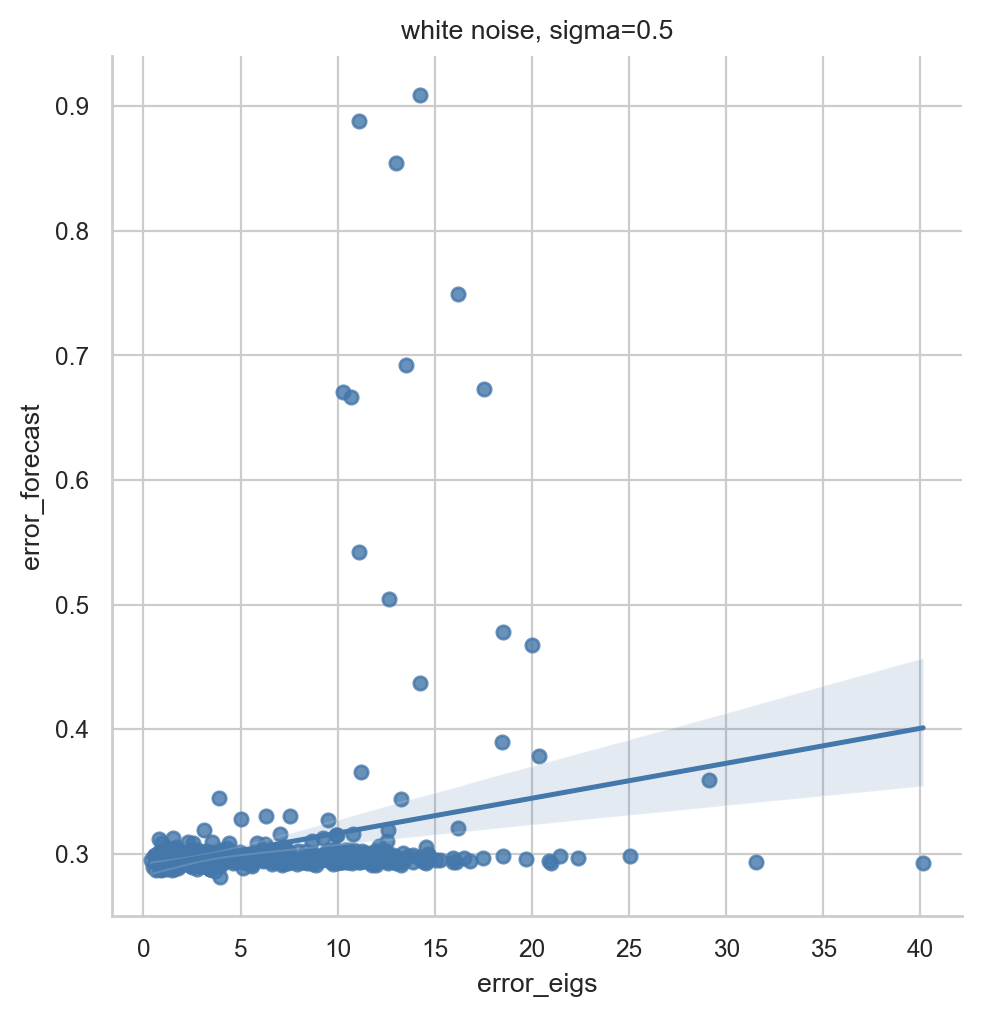

In [31]:
plt.figure()
sns.lmplot(data=ds_bopdmd.mean(dim='eigenvalue').sel(sigma=0.1).to_dataframe().reset_index(), x='error_eigs', y='error_forecast')
plt.gca().set_title('white noise, sigma=0.1')

plt.figure()
sns.lmplot(data=ds_bopdmd.mean(dim='eigenvalue').sel(sigma=0.5).to_dataframe().reset_index(), x='error_eigs', y='error_forecast')
plt.gca().set_title('white noise, sigma=0.5')